# Computational Statistics Project Script
This notebook is paired with the document. For the purpose of explaining aims, outputs and general design, please refer to the pdf. Many concepts require theoretical introduction and explanations that are more suitable for a latex typed document. 

## Configuration

In this section we build the environment with imports and necessary settings

In [1]:
pip install scipy --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
######### IMPORTS ############################

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from scipy.stats import norm, multivariate_normal, bernoulli, multivariate_t, uniform, truncnorm
from scipy.optimize import minimize
from scipy.stats import kde
import pandas as pd
import time
import datetime
#####################################################
###### MATPLOTLIB SETTINGS #########################
# we should avoid this for later purposes %matplotlib inline
plt.rc('legend', fontsize=11)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
#####################################################

In [3]:
###### GITHUB REPOSITORY CLONING #############################################
#! git init
#! git clone https://github.com/simonegiancola09/probit_bayesian_MCMC.git
##########################################################################################

In [4]:
####### SIMULATED DATA GLOBAL VARIABLES ###############

np.random.seed(6377)                             # seed
p = 2                                          # number of variables
n = 1000                                        # number of observations
X = np.ones((n , 1), dtype = int)                # intercept
X = np.hstack((X, multivariate_normal(mean = np.zeros(p), cov = 3 * np.eye(p)).rvs(size = n)))  # random gaussian covariates
beta_true = np.random.normal(scale = 2, size = p + 1).reshape((p + 1, 1))                       # true coefficients
et = np.dot(X, beta_true)
means = norm.cdf(et)
Y = bernoulli.rvs(p = means,size = (n, 1))       #simulated dependent variable
######################################################

print("True beta:", beta_true.flatten()) # flattened to make it fancier at print
# print('Mean of data generating process for Y:', np.mean(means))

True beta: [-3.81943841 -1.66849063 -1.94069479]


In [5]:
Y.shape, X.shape

((1000, 1), (1000, 3))

In [6]:
####### IITIAL CONFIGURATION ###############
beta_0 = np.zeros((p+1,1))
#beta_ols = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y)) might be used
tau_try = 3
burnin_try = 0
iterations_after_burnin_try = 10000
print('Starting beta', beta_0.flatten(), '\nBeta true:', beta_true.flatten())
##################################################

Starting beta [0. 0. 0.] 
Beta true: [-3.81943841 -1.66849063 -1.94069479]


In [7]:
##### ALL ZEROS GLOBAL VARIABLES #######################################
beta_null = np.zeros((p + 1, 1))
Var_null = np.eye(p+1)
##############################################################################

In [8]:
##### ALL ONES GLOBAL VARIABLES #######################################
beta_ones = np.ones(p + 1)
Var_ones = np.eye(p+1)
##############################################################################

In [9]:
####### MLE GLOBAL VARIABLES ####################################
from statsmodels.discrete.discrete_model import Probit
try:
    probit_MLE = Probit(Y, X)
    result_MLE = probit_MLE.fit()
    print(result_MLE.summary())
    beta_MLE = result_MLE.params
    Var_MLE = result_MLE.cov_params()
    beta_MLE = beta_MLE.flatten()
    found_MLE = True
except:
    found_MLE = False
#########################################################################

Optimization terminated successfully.
         Current function value: 0.109297
         Iterations 10
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                         Probit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Thu, 20 Jan 2022   Pseudo R-squ.:                  0.7752
Time:                        13:29:45   Log-Likelihood:                -109.30
converged:                       True   LL-Null:                       -486.22
Covariance Type:            nonrobust   LLR p-value:                2.009e-164
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7156      0.322    -11.554      0.000      -4.346      -3.085
x1            -1.6428      0

In [10]:
#### OLS GLOBAL VARIABLES #############################################
try:
    beta_OLS, res_OLS, _, _ = np.linalg.lstsq(X, Y, rcond = None)
    # Var_OLS estimate is usual formula
    Var_OLS = np.dot(np.dot(res_OLS.T, res_OLS), np.linalg.inv(np.dot(X.T, X))) / (n - p + 1)

    beta_OLS = beta_OLS.flatten()
    found_OLS = True

except:
    found_OLS = False
#########################################################################   

In [11]:
def starting_betas(dim, n_random_betas = 0, null = True, ones = True):
    '''
    p = dimension
    n_random_betas: add n random values of starting betas (default 0)
    beta_null = add beta of all zeros if True
    '''
    beta_dict = {}
    if found_MLE:
        beta_dict['MLE'] = beta_MLE
    if null: 
        beta_dict['null'] = np.zeros(dim)
    if found_OLS:
        beta_dict['OLS'] = beta_OLS
    if ones:
        beta_dict['ones'] = np.ones(dim)
    for i in range(n_random_betas):
        beta_dict[f'random_{i}'] = np.random.normal(scale = np.random.randint(1,5), size = dim) 
    return beta_dict
  

beta_dict = starting_betas(p+1, n_random_betas=2)
beta_dict

{'MLE': array([-3.71560358, -1.6427645 , -1.93294701]),
 'null': array([0., 0., 0.]),
 'OLS': array([ 0.19618706, -0.10538307, -0.1131828 ]),
 'ones': array([1., 1., 1.]),
 'random_0': array([-0.87039329,  0.08494298,  0.93727591]),
 'random_1': array([0.33294902, 0.06074721, 1.35036777])}

## Defining global variables and importing scripts

The script was meant to be together, then it got too big. Here we save some variables that are intended as global. Indeed, this split of the code is not for the purpose of making it a package. A direction of improvement would be implemeting everything in terms of classes.

In [12]:
import builtins
colors = ['tab:cyan', 'tab:purple', 'tab:olive', 'tab:red', 'tab:orange',
                  'tab:brown', 'tab:pink', 'tab:gray', 'tab:green', 'tab:blue']
builtins.colors = colors
builtins.p = p
builtins.beta_MLE = beta_MLE
builtins.Var_MLE = Var_MLE
builtins.beta_true = beta_true
builtins.Y = Y
builtins.X = X
#################################################

In [13]:
### GITHUB IMPORTS #############################################
# TODO maybe
# % cd /content/probit_bayesian_MCMC

from linear_algebra_functions import (
    eta,
    fisher_info,
    phi_normal
)
'''
builtins.fisher_info = fisher_info
builtins.eta = eta
builtins.phi_normal = phi_normal
'''
from bayes_functions import (
    prior_MLE, prior_uninformative, posterior_beta_Y,
    prior_Standard_Normal,
    likelihood, prior_t_student, plot_likelihood
)
'''
builtins.prior_uninformative = prior_uninformative
builtins.posterior_beta_Y = posterior_beta_Y

builtins.prior_MLE = prior_MLE
builtins.prior_uninformative = prior_uninformative
builtins.prior_t_student = prior_t_student
MH_priors = {prior_MLE : 'Standard Normal',
             prior_uninformative : 'Uninformative prior',
             prior_t_student : 'Multivariate_t_student'}
'''
from metrop_funcs import (
    proposal_beta_new, acceptance, MetropolisAlgorithm
)
from gibbs_funcs import (
    diffuse_full_conditional_beta,
    standard_normal_full_conditional_beta,
    normal_MLE_full_conditional_beta,
    draw_from_truncated,
    Auxiliary_Gibbs_Sampling
)
'''
builtins.MetropolisAlgorithm = MetropolisAlgorithm
builtins.Auxiliary_Gibbs_Sampling = Auxiliary_Gibbs_Sampling
'''
from plot_functions import (
    plot_trace_dimension,
    multi_plot_chain,
    plot_autocorrelation,
    plot_cumulative_mean,
    plot_alpha,
    plot_accepted_rejected, 
    plot_density_dimension
)
from plot_chain_and_comparison import(
    plot_double_dim_accepted_rejected,
    plot_triple_dim_accepted_rejected
)
''' 
from difference_settings_plots import(
    plot_different_priors,
    plot_normal_priors_different_stretch,
    plot_different_starting_betas,
    plot_different_taus
)
'''

' \nfrom difference_settings_plots import(\n    plot_different_priors,\n    plot_normal_priors_different_stretch,\n    plot_different_starting_betas,\n    plot_different_taus\n)\n'

## Difference plots

In [14]:
#### PLOT DIFFERENTS ##########################################################
# graphical exploration of different settings for the algorithm

def plot_different_priors(starting_point = np.zeros(p+1), tau = 2, iterations = 5000, priors = None):
    '''
    Plot the cumulative mean evolution of the result using different prior specifications in the algorithm.
    Can specify a priors dictionary with custom names and functions or use the default one. 
    Default is standard normal, uninformative and multivariate t student
    '''
    dim = starting_point.shape[0]
    fig, ax = plt.subplots(dim, figsize = (15,15))
    if priors is None:
        priors = {prior_MLE : "Normal_MLE", prior_uninformative : "Uninformative", 
                prior_t_student : "Multivariate_t_student", prior_Standard_Normal : "Multivariate_standard_normal" }
    l = []
    for prior in priors.keys():
        print(f'Prior is: {priors[prior]}')
        betas, mean_betas, _, _ = MetropolisAlgorithm(Y, X, starting_point, tau = tau, burnin = 0, iterations_after_burnin = iterations, log=True, verbose=False)
        l.append(betas)
    keys = list(priors.keys())
    for dimension in range(dim):
        for i in range(len(l)):
            axis_ = ax[dimension]
            axis_.plot(l[i][:,dimension].cumsum()/np.arange(1,iterations+1), label = priors[keys[i]])
            axis_.set_title('Dimension {}'.format(dimension), fontsize = 10)
        axis_.hlines(beta_true[dimension], 0, iterations, color = "black", label = f"beta_{dimension}_true", ls='--')
        axis_.legend()
    plt.suptitle('Different Priors', size=16)
    plt.subplots_adjust(top=.95)
    plt.close(fig)
    return fig


def plot_normal_priors_different_stretch(starting_point = np.zeros(p+1), tau = 3, stretch = [1,5, 100], iterations = 5000):
    '''
    Plot the cumulative mean evolution of the result using different stretch for the normal prior with cov matrix stretch*I.
    Here the hypermarameter of the model such as tau and iterations are predefined, also the starting point beta_0. However
    it is possible to customize them during the call of the function.
    '''
    keys = []
    priors = dict()
    for i in range(len(stretch)):
        keys.append(lambda x: prior_MLE(x, stretch = stretch[i]))
        priors[keys[i]] = f"Prior with stretch {stretch[i]}"
    l = []
    dim = starting_point.shape[0]
    fig, ax = plt.subplots(dim, figsize = (15,15))
    for prior in priors.keys():
            print(f'{priors[prior]}')
            betas, mean_betas, _, _ = MetropolisAlgorithm(Y, X, beta_0, tau_try, 0, iterations, log=True, verbose=False)
            l.append(betas)
    keys_2 = list(priors.keys())
    for dimension in range(dim):
        for i in range(len(l)):
            axis_ = ax[dimension]
            axis_.plot(l[i][:,dimension].cumsum()/np.arange(1,iterations+1), label = priors[keys_2[i]] )
            axis_.set_title('Dimension {}'.format(dimension), fontsize = 10)
        axis_.hlines(beta_true[dimension], 0, iterations, color = "black", label = f"beta_{dimension}_true", ls='--')
        axis_.legend()
    plt.suptitle('Different Stretches')
    plt.subplots_adjust(top=.95)
    plt.close(fig)
    return fig


def plot_different_starting_betas(algorithm, starting_values, dimension, tau = 1, iterations=5000):
    '''
    Plot the cumulative mean evolution of the result using different starting points.
    Here the hypermarameter of the model such as tau and iterations are predefined. However
    it is possible to customize them during the call of the function.
    You have also to specify which dimension of the resulting beta you want to plot.
    '''

    fig, ax = plt.subplots(dimension, figsize=(15,30))
    
    for i in starting_values:
        beta_0 = starting_values[i]
        print(f'Starting point at iteration {i}: {beta_0.flatten()}')
        if algorithm == 'Metropolis':
            betas, mean_betas, _, _ = MetropolisAlgorithm(Y, X, beta_0, tau = tau,
                                                      burnin = 0, iterations_after_burnin = iterations,
                                                      log=True, verbose=False)
        else:
            betas, mean_betas = Auxiliary_Gibbs_Sampling(beta_0, Y, X, burnin=0, iterations_after_burnin=iterations,
                                 print_warning_every = 500, prior = diffuse_full_conditional_beta,
                                 verbose = False)
        for j in range(dimension):
            ax[j].plot(betas[:,j].cumsum()/np.arange(1,iterations+1), label=i)
            ax[j].title.set_text(f'Dimension {j}')
            ax[j].legend()
    for i in range(dimension):
        ax[i].hlines(beta_true[i], 0, iterations, label='True Beta', color='black', ls='--')
        ax[i].legend()
    fig.suptitle('Different Starting Points')
    plt.subplots_adjust(top=.95)
    plt.ylabel('Cumulative Mean')
    plt.xlabel('Iterations')
    plt.subplots_adjust(top=.95)

    plt.close(fig)
    return fig


def plot_different_taus(plot_type, tau_low, tau_high, dimension, iterations=5000):
    '''
    Plot the cumulative mean (plot_type != Acceptance) or the Acceptance rate (plot_type = Acceptance) using 
    different values of taus. The function takes as parameter the lowest and highest value of tau to use.
    You have also to specify which dimension of the resulting beta you want to plot.
    '''
    tau = np.hstack((np.array([0.25, 0.5]),np.arange(tau_low, tau_high)))
    beta_0 = np.zeros((p+1,1))
    fig = plt.figure(figsize=(12,10))
    #alphas = []
    for i in tau:
        betas, _, _, accepted = MetropolisAlgorithm(Y, X, beta_0, i, 0, iterations, log=True, verbose=False)
        if plot_type=='Acceptance':
            #cum = 1-accepted.cumsum()/np.arange(1, iterations+1)
            #alphas.append(cum[-1])
            plt.plot(1-accepted.cumsum()/np.arange(1, iterations+1), label='tau = {}'.format(i))
            plt.ylabel('Acceptance Proportion')
        else:
            plt.plot(betas[:,dimension].cumsum()/np.arange(1,iterations+1), label='tau = {}'.format(i))
            plt.ylabel('Cumulative Mean')
    if plot_type != 'Acceptance':
        plt.hlines(beta_true[dimension], 0, iterations, label = 'beta {} true'.format(dimension))
      
    plt.title('Different Taus')
    plt.xlabel('Iterations')
    plt.legend()
    plt.close(fig)
    #print(alphas)
    return fig



def plot_different_priors_Gibbs(starting_point = np.zeros((p+1,1)), burn = 1000, iterations = 10000
                          , full_conditionals = None):
    '''
    Plot the cumulative mean evolution of the result using different prior specifications in the algorithm.
    Can specify a priors dictionary with custom names and functions or use the default one. 
    Default is standard normal, uninformative and multivariate t student
    '''
    dim = starting_point.shape[0]
    fig, ax = plt.subplots(dim, figsize = (15,15))
    #aux_f = lambda z,X : normal_full_conditional_beta(z, X, stretch = 10)
    if full_conditionals is None:
        priors = {diffuse_full_conditional_beta : "Diffuse full conditional", 
                standard_normal_full_conditional_beta : "Normal centerd in 0 with stretch 10",
               normal_MLE_full_conditional_beta : "Normal centered MLE"}
    l = []
    for prior in priors.keys():
        print(f'Prior is: {priors[prior]}')
        #if prior == diffuse_full_conditional_beta:
         #   k = "diffuse"
        #else:
         #   k = " "
        betas, mean_betas = Auxiliary_Gibbs_Sampling(starting_point, Y, X, burnin = burn,
                                        iterations_after_burnin = iterations, prior = prior, verbose = False)
        l.append(betas)
    keys = list(priors.keys())
    for dimension in range(dim):
        for i in range(len(l)):
            axis_ = ax[dimension]
            axis_.plot(l[i][:,dimension].cumsum()/np.arange(1,iterations+1), label = priors[keys[i]] )
        axis_.set_title(f'Dimension {dimension}')
        axis_.hlines(beta_true[dimension], 0, iterations, color = "black", label = f"beta_{dimension}_true", ls='--')
        axis_.legend()
    plt.suptitle('Different Priors for Gibbs', size=16)
    plt.subplots_adjust(top=.95)
    plt.close(fig)
    return fig
    
  ##################################################
  ##################################################

## Finding the best Configuration

Prior is: Normal_MLE
Computation starts
Mean at termination: [-3.68045047 -1.62753822 -1.91889626]
Prior is: Uninformative
Computation starts
Mean at termination: [-3.66051165 -1.62119268 -1.90083591]
Prior is: Multivariate_t_student
Computation starts
Mean at termination: [-3.64925985 -1.61099077 -1.89957696]
Prior is: Multivariate_standard_normal
Computation starts
Mean at termination: [-3.67808495 -1.62326202 -1.9066715 ]


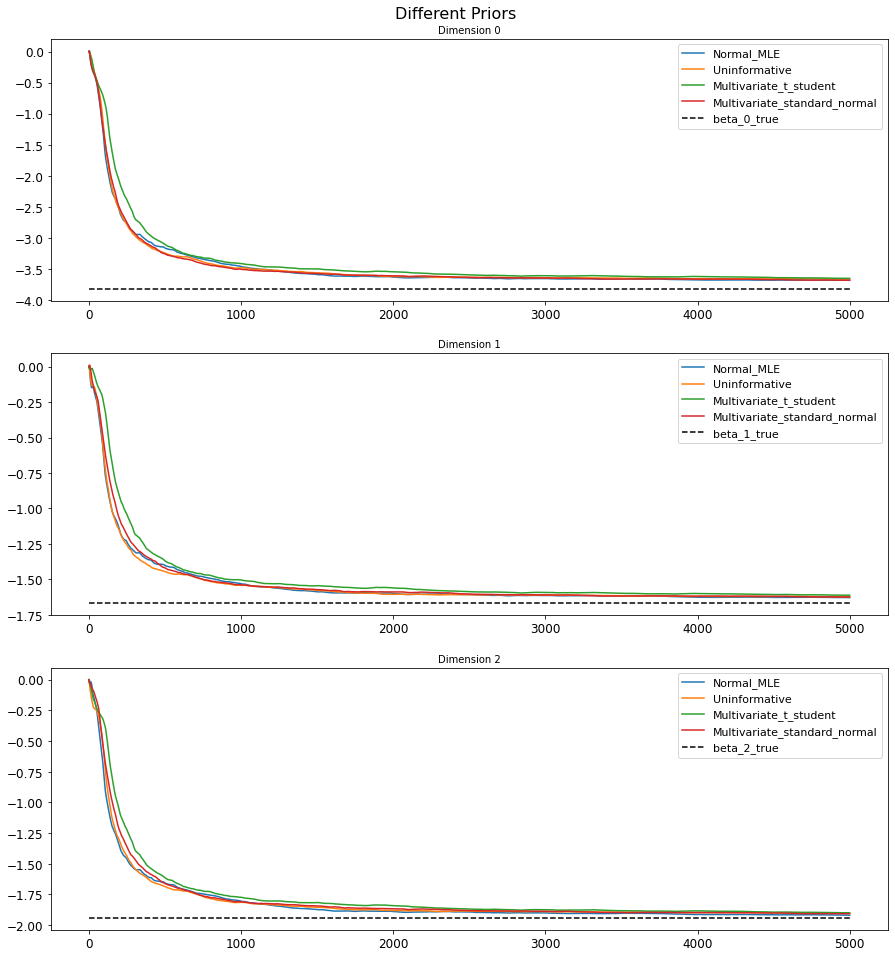

In [15]:
diff_priors_plot = plot_different_priors(starting_point = np.zeros(p+1), tau = 2, iterations = 5000, priors = None)
diff_priors_plot.savefig('imgs/different_priors_MH_alg')
diff_priors_plot

Prior with stretch 1
Computation starts
Mean at termination: [-3.67107987 -1.62310057 -1.90768423]
Prior with stretch 5
Computation starts
Mean at termination: [-3.6821826  -1.62820718 -1.91924631]
Prior with stretch 100
Computation starts
Mean at termination: [-3.68497627 -1.63148391 -1.9192829 ]


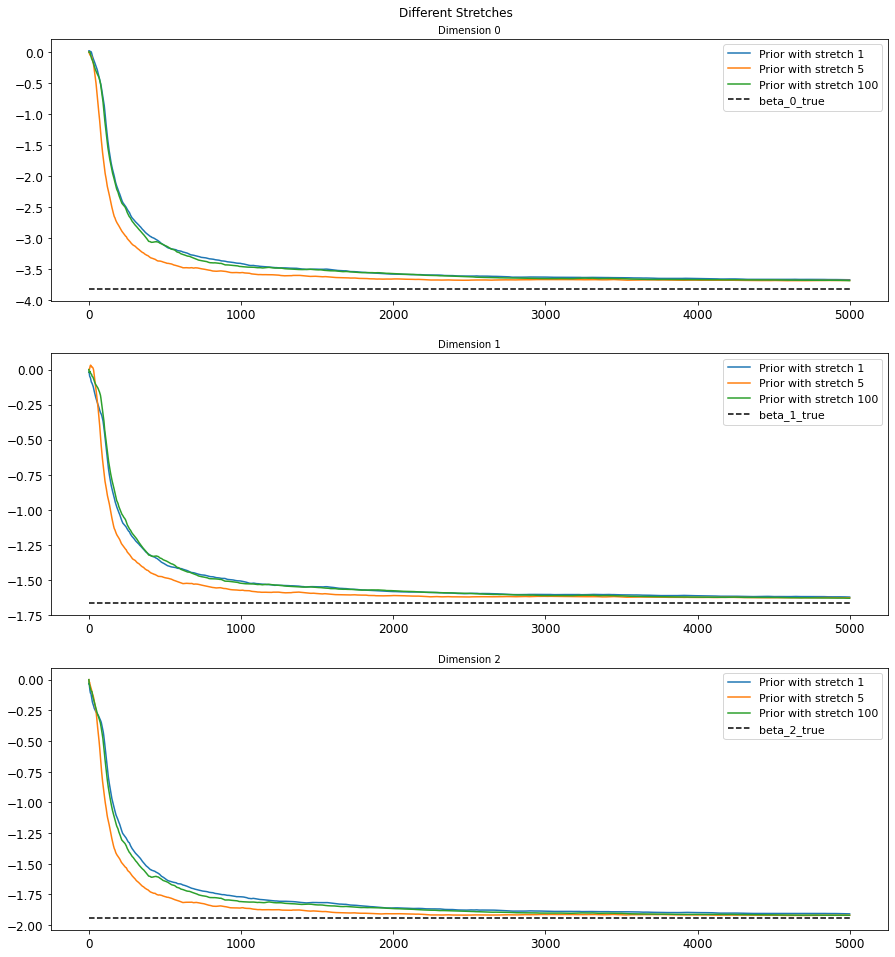

In [16]:
diff_stretch_plot = plot_normal_priors_different_stretch(starting_point = np.zeros(p+1), tau = 3, stretch = [1,5, 100], iterations = 5000)
diff_stretch_plot.savefig('imgs/diff_stretch_MHalg')
diff_stretch_plot

In [17]:
beta_dict = starting_betas(dim=3, n_random_betas = 3, null = True, ones = False)
beta_dict

{'MLE': array([-3.71560358, -1.6427645 , -1.93294701]),
 'null': array([0., 0., 0.]),
 'OLS': array([ 0.19618706, -0.10538307, -0.1131828 ]),
 'random_0': array([ 0.75460664,  0.55113813, -0.03647229]),
 'random_1': array([-1.40702212, -0.8812357 ,  0.41129986]),
 'random_2': array([0.7551233 , 0.61262711, 1.86527356])}

Starting point at iteration MLE: [-3.71560358 -1.6427645  -1.93294701]
Computation starts
Mean at termination: [-3.73430635 -1.64936433 -1.94187276]
Starting point at iteration null: [0. 0. 0.]
Computation starts
Mean at termination: [-3.72380643 -1.64377075 -1.93862983]
Starting point at iteration OLS: [ 0.19618706 -0.10538307 -0.1131828 ]
Computation starts
Mean at termination: [-3.69595785 -1.63219802 -1.92721813]
Starting point at iteration random_0: [ 0.75460664  0.55113813 -0.03647229]
Computation starts
Mean at termination: [-3.70094753 -1.63633601 -1.92817145]
Starting point at iteration random_1: [-1.40702212 -0.8812357   0.41129986]
Computation starts
Mean at termination: [-3.74479734 -1.65490999 -1.93846561]
Starting point at iteration random_2: [0.7551233  0.61262711 1.86527356]
Computation starts


/Users/admin/Desktop/University/Master_of_science/MS_Bocconi/1_First_year/first_semester/Statistics_and_Probability/computational_statistics_module/Graded/submission/script_and_dataset/bayes_functions.py:49: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(prob ** Y * (1 - prob) ** (1 - Y)))
/Users/admin/Desktop/University/Master_of_science/MS_Bocconi/1_First_year/first_semester/Statistics_and_Probability/computational_statistics_module/Graded/submission/script_and_dataset/metrop_funcs.py:27: RuntimeWarning: invalid value encountered in double_scalars
  return a - b


Mean at termination: [-3.61735415 -1.58986547 -1.86151955]


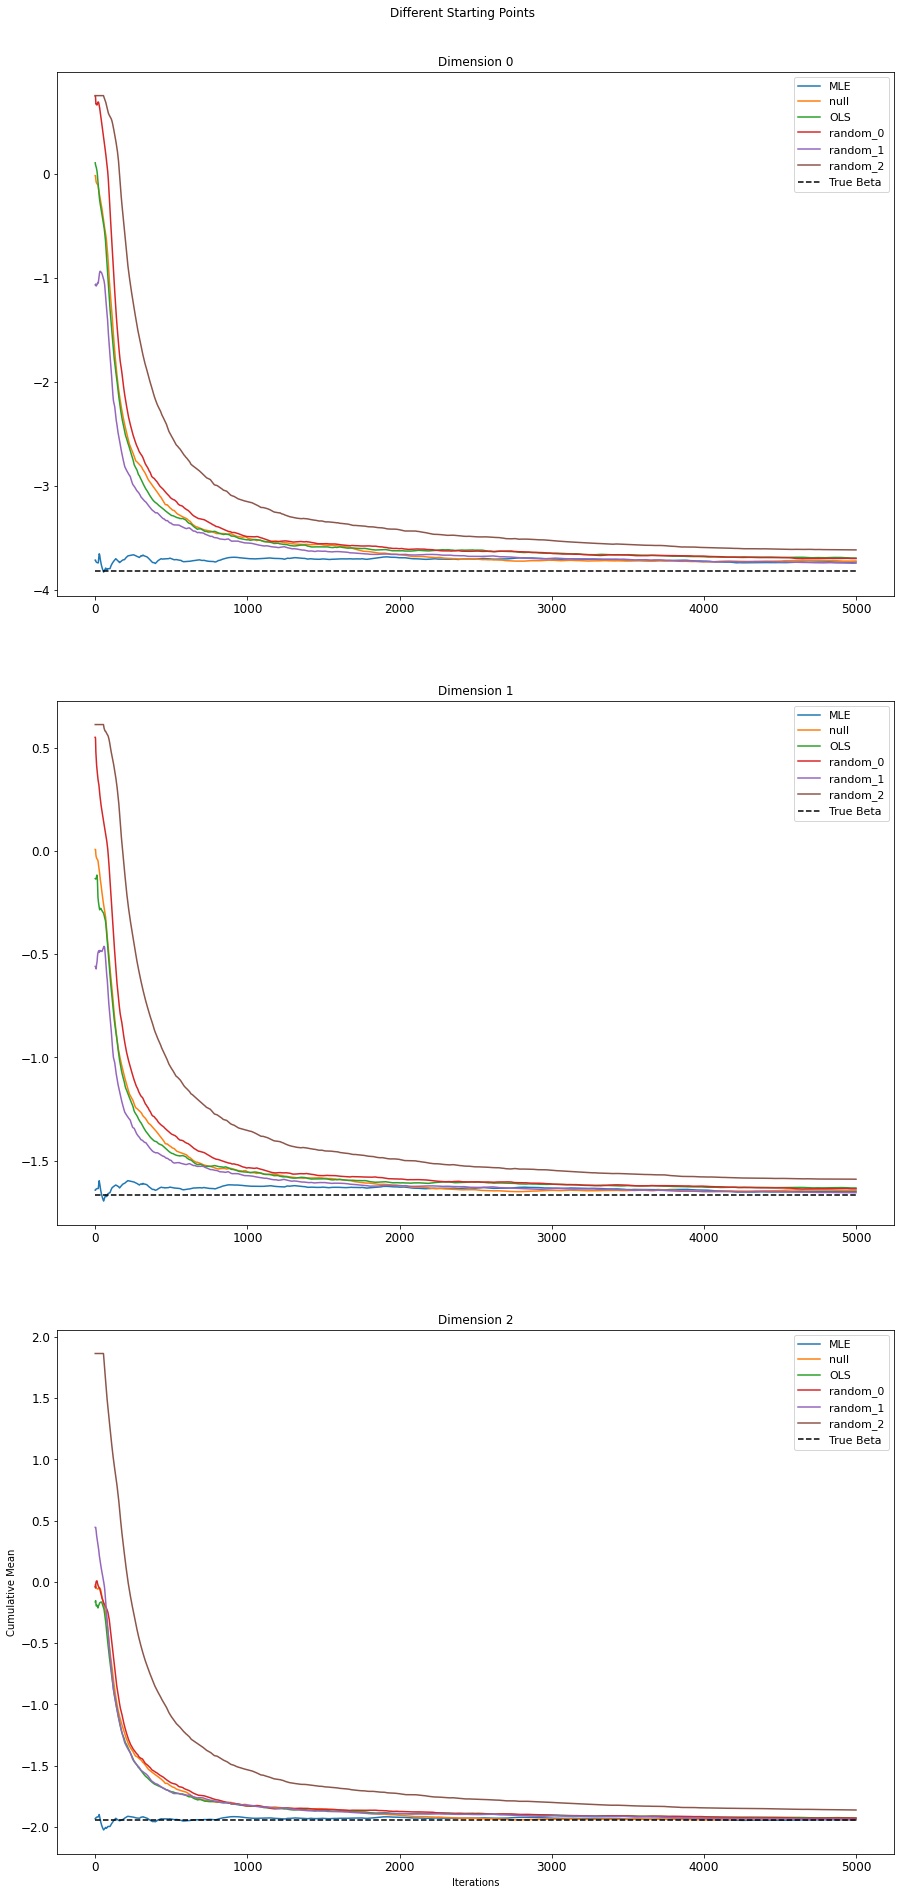

In [18]:
diff_beta_0_plot = plot_different_starting_betas(algorithm='Metropolis',starting_values=beta_dict, dimension=p+1, tau=5, iterations=5000)
diff_beta_0_plot.savefig('imgs/diff_beta_0_plots')
diff_beta_0_plot

Starting point at iteration MLE: [-3.71560358 -1.6427645  -1.93294701]
Computation starts
Mean at termination: [-3.73307496 -1.65160788 -1.93931129]
Starting point at iteration null: [0. 0. 0.]
Computation starts
Mean at termination: [-3.64739041 -1.61813927 -1.89602777]
Starting point at iteration OLS: [ 0.19618706 -0.10538307 -0.1131828 ]
Computation starts
Mean at termination: [-3.74305033 -1.65596283 -1.94817453]
Starting point at iteration random_0: [ 0.75460664  0.55113813 -0.03647229]
Computation starts
Mean at termination: [-3.5168531  -1.55321917 -1.825581  ]
Starting point at iteration random_1: [-1.40702212 -0.8812357   0.41129986]
Computation starts
Mean at termination: [-3.62359262 -1.59994121 -1.8830431 ]
Starting point at iteration random_2: [0.7551233  0.61262711 1.86527356]
Computation starts
Mean at termination: [nan nan nan]


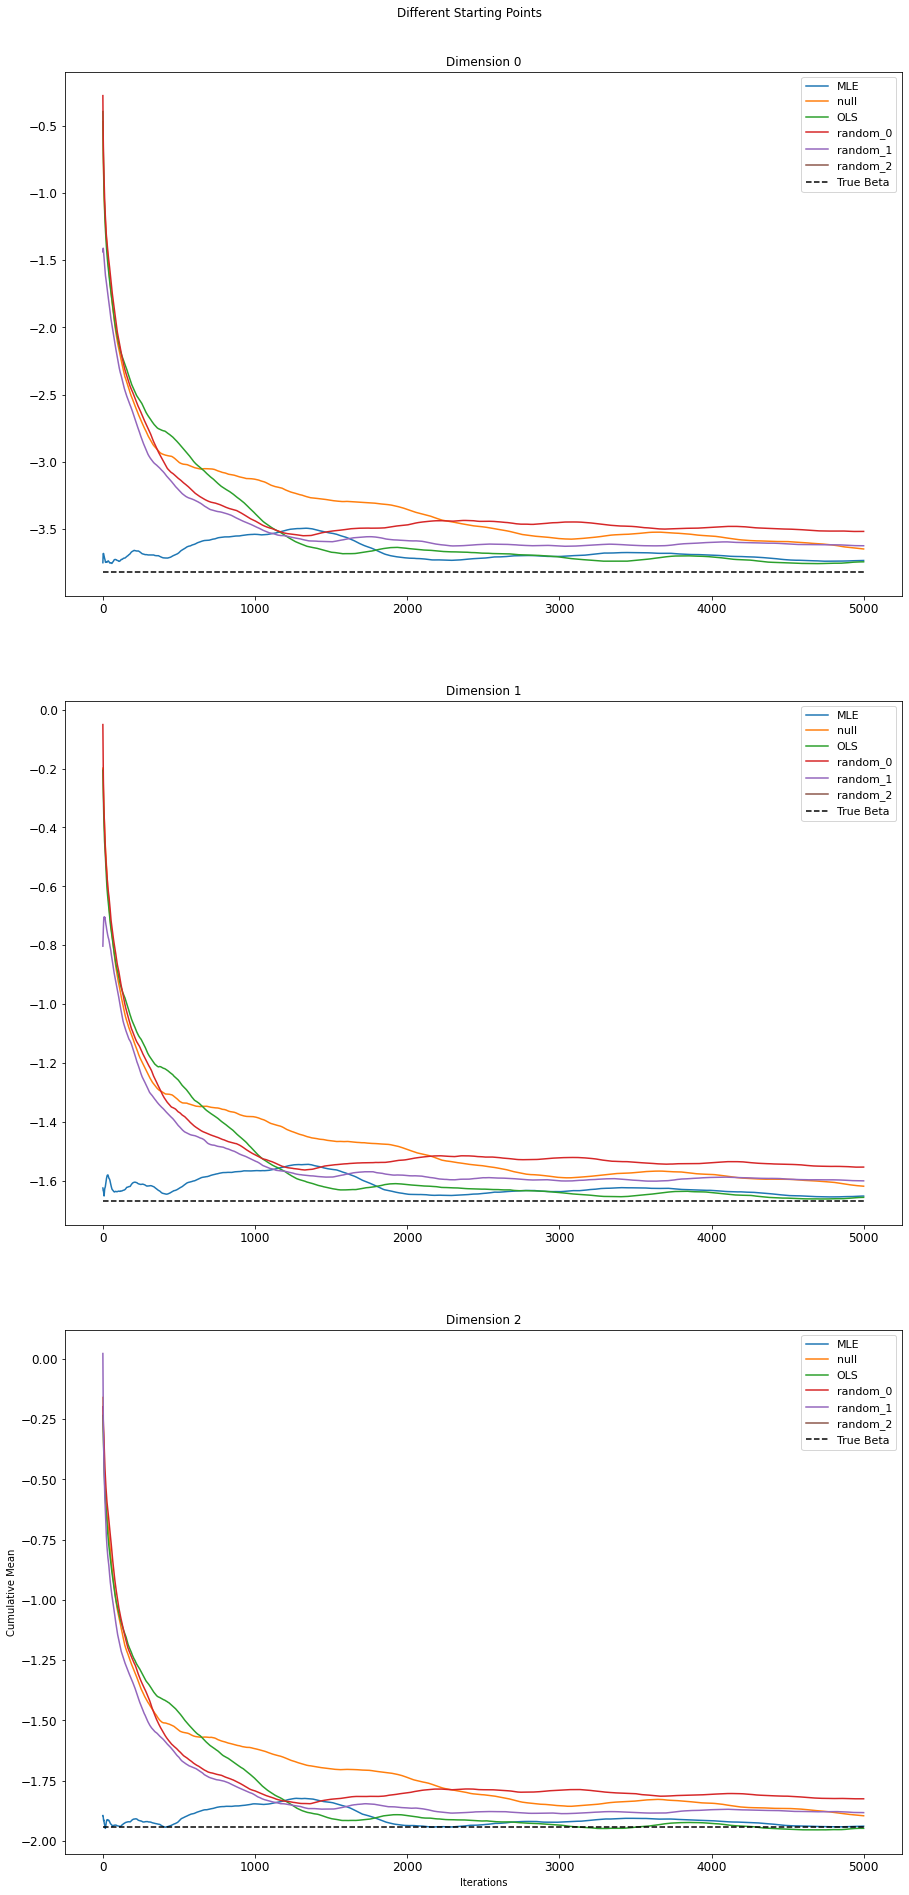

In [19]:
diff_beta_0_plot_gibbs = plot_different_starting_betas(algorithm='Gibbs',starting_values=beta_dict, dimension=p+1, tau=5, iterations=5000)
diff_beta_0_plot_gibbs.savefig('imgs/diff_beta_0_plots_gibbs')
diff_beta_0_plot_gibbs

Computation starts
Mean at termination: [-3.31357773 -1.45609972 -1.70433855]
Computation starts
Mean at termination: [-3.42870597 -1.50505795 -1.76986228]
Computation starts
Mean at termination: [-3.5900808  -1.5896747  -1.86632186]
Computation starts
Mean at termination: [-3.62150376 -1.60193147 -1.88682283]
Computation starts
Mean at termination: [-3.64778334 -1.60855605 -1.89932957]
Computation starts
Mean at termination: [-3.56965696 -1.57169287 -1.85312114]
Computation starts
Mean at termination: [-3.66642203 -1.62708143 -1.91101672]


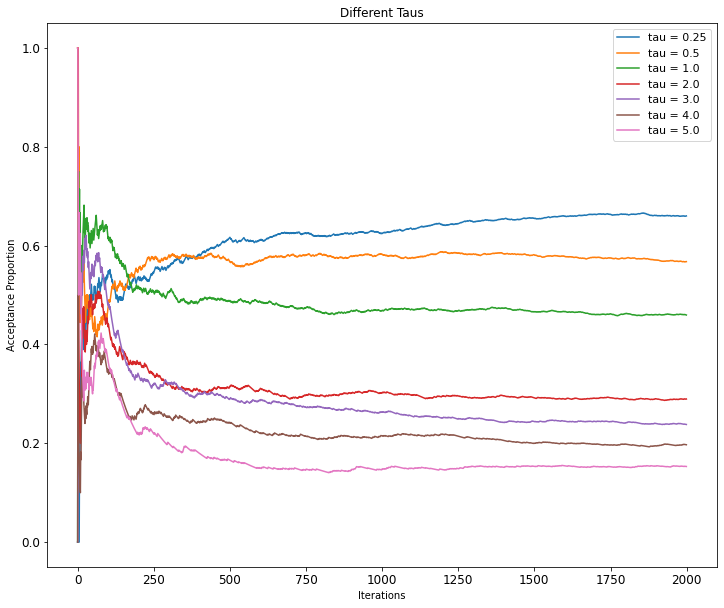

In [20]:
diff_tau_plot = plot_different_taus('Acceptance', 1, 6, 0, 2000)
diff_tau_plot.savefig('imgs/diff_tau_plot_MH_acceptance.png')
diff_tau_plot

Prior is: Diffuse full conditional
Computation starts
Mean at termination: [-3.62970268 -1.59749623 -1.88293543]
Prior is: Normal centerd in 0 with stretch 10
Computation starts
Mean at termination: [-3.66259985 -1.61997244 -1.9024955 ]
Prior is: Normal centered MLE
Computation starts
Mean at termination: [-3.62387407 -1.60075237 -1.8838996 ]


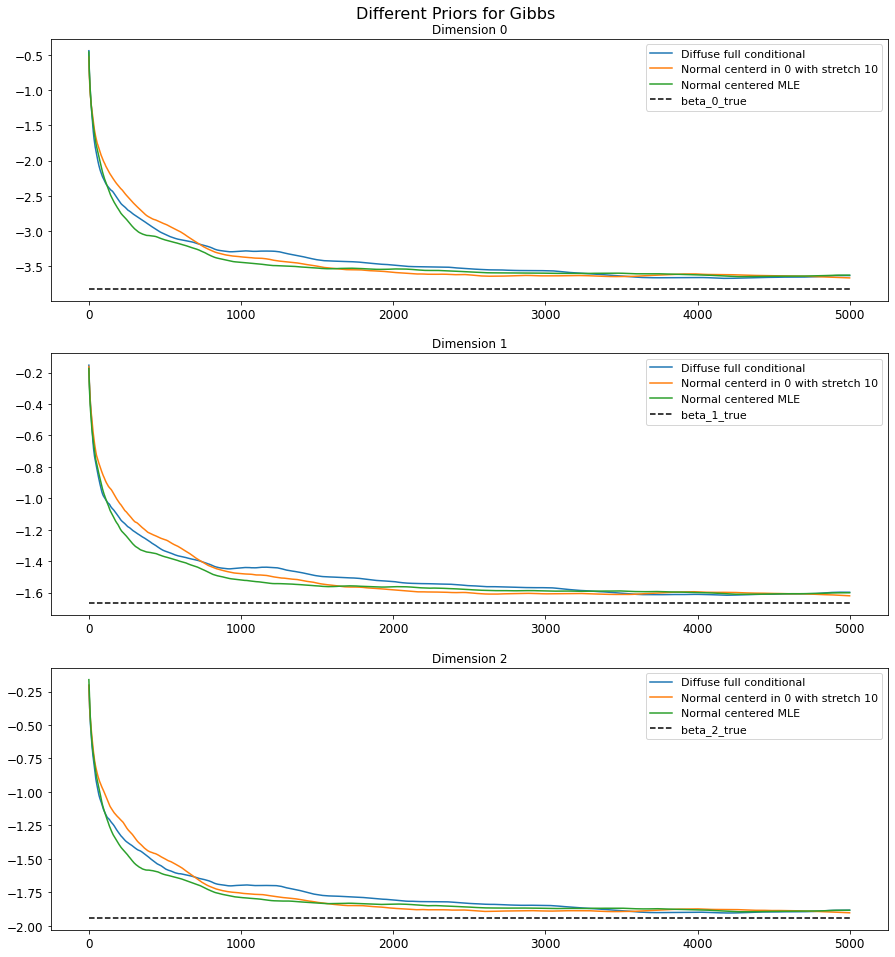

In [21]:
plot_different_priors_G = plot_different_priors_Gibbs(starting_point = beta_0, burn = 0, iterations = 5000, full_conditionals = None)
plot_different_priors_G.savefig('imgs/plot_different_priors_Gibbs')
plot_different_priors_G

## Using a suitable configuration

### Metropolis-Hastings

In [22]:
####### BEST CONFIGURATION VALUES MH ALGORITHM ###############
beta_0 = np.zeros((p+1,1))
#beta_ols = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y)) might be used
tau_try = 2
burnin_try = 1000
iterations_after_burnin_try = 10000
print('Starting beta', beta_0.flatten(), '\nBeta true:', beta_true.flatten())
##################################################

Starting beta [0. 0. 0.] 
Beta true: [-3.81943841 -1.66849063 -1.94069479]


In [23]:
####### RUNNING METROPOLIS ALGORITHM ###############
print('We are running starting from {}, with as variance factor tau = {}\n'.format(beta_0.flatten(), tau_try))
print('As Burn-in we will iterate {} times and collect a sample of a hopefully stationary ergodic distribution of dimension {}\n'.format(burnin_try, iterations_after_burnin_try))
start = time.time()
betas_try, betas_mean_try, rejected, acc_rej = MetropolisAlgorithm(Y, X, beta_0, tau_try, burnin_try, \
                                                                   iterations_after_burnin_try, log=True, prior=prior_uninformative)
end = time.time()
print(f'Time elapsed: {end - start} seconds')
##################################################

We are running starting from [0. 0. 0.], with as variance factor tau = 2

As Burn-in we will iterate 1000 times and collect a sample of a hopefully stationary ergodic distribution of dimension 10000

Computation starts
Reached 500 iterations of burn-in, so far 163 values were accepted. 
Acceptance proportion is 0.33

Reached 1000 iterations of burn-in, so far 297 values were accepted. 
Acceptance proportion is 0.3

Starting to run the ergodic chain...
Reached 500 iterations of the ergodic chain
Reached 1000 iterations of the ergodic chain
Reached 1500 iterations of the ergodic chain
Reached 2000 iterations of the ergodic chain
Reached 2500 iterations of the ergodic chain
Reached 3000 iterations of the ergodic chain
Reached 3500 iterations of the ergodic chain
Reached 4000 iterations of the ergodic chain
Reached 4500 iterations of the ergodic chain
Reached 5000 iterations of the ergodic chain
Reached 5500 iterations of the ergodic chain
Reached 6000 iterations of the ergodic chain
Reach

In [24]:
print('Resulting beta', betas_mean_try.flatten(), '\n True Beta', beta_true.flatten())
print('Mean Square Error:', np.sum((betas_mean_try.flatten() - beta_true.flatten()) ** 2) / beta_true.shape[0])
##################################################

Resulting beta [-3.72691457 -1.64721061 -1.93628668] 
 True Beta [-3.81943841 -1.66849063 -1.94069479]
Mean Square Error: 0.0030109769876974623


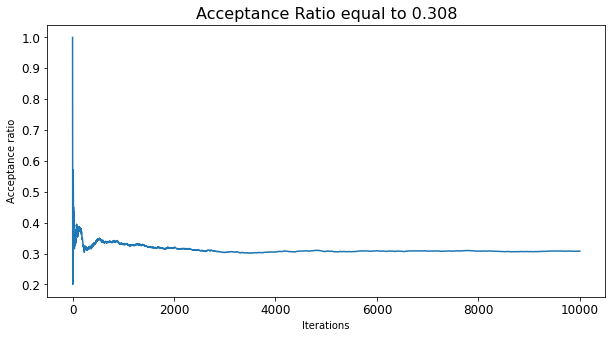

In [25]:
alpha = plot_alpha(acc_rej, iterations_after_burnin_try)
alpha.savefig('imgs/acceptance')
alpha

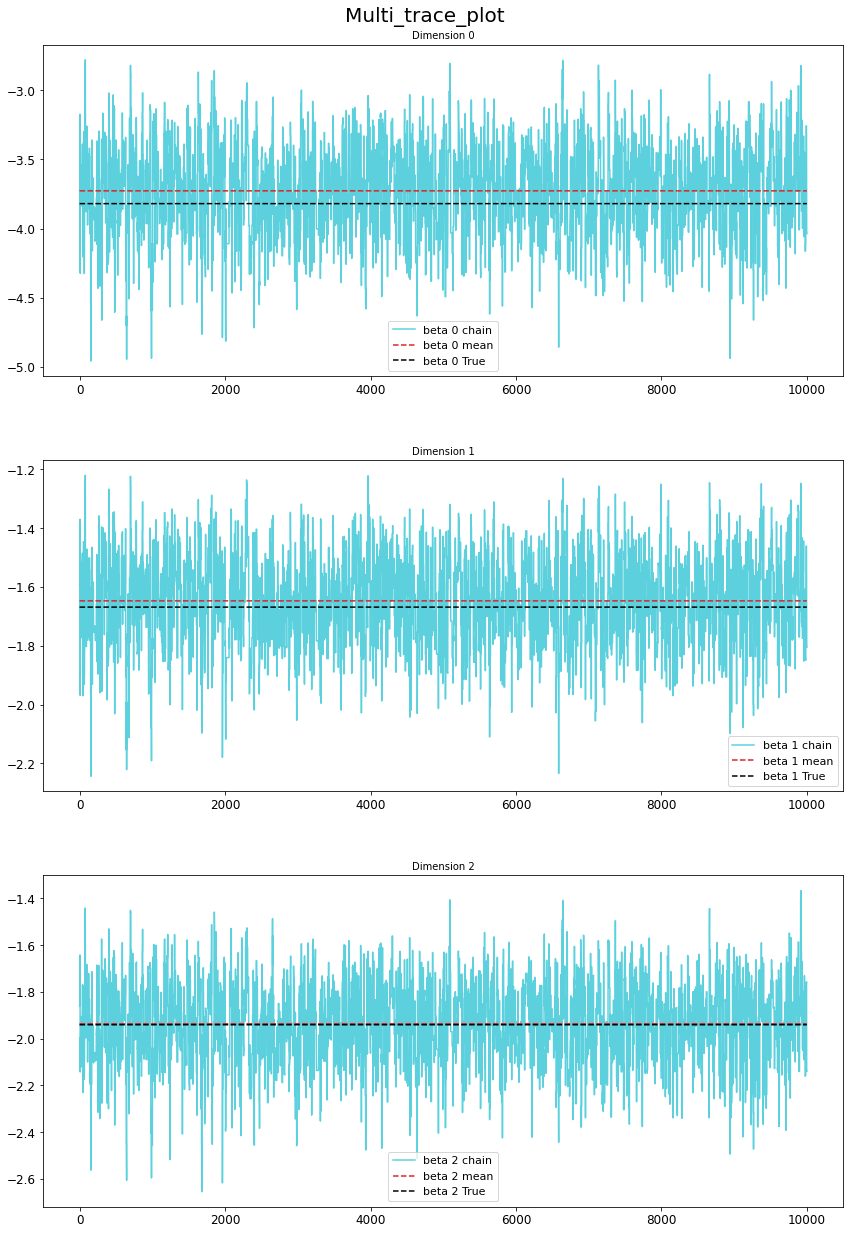

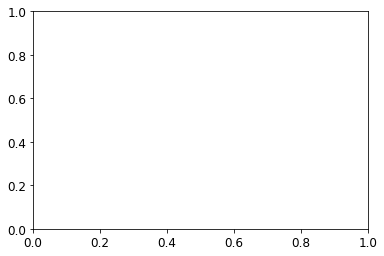

In [26]:
## TRACE PLOTS #################################################################
multi_trace_plot = multi_plot_chain(betas_try, plot_trace_dimension, title = 'trace', fig_size=(13,18))
multi_trace_plot.savefig('imgs/multi_trace_plot_MH')
multi_trace_plot
################################################################################

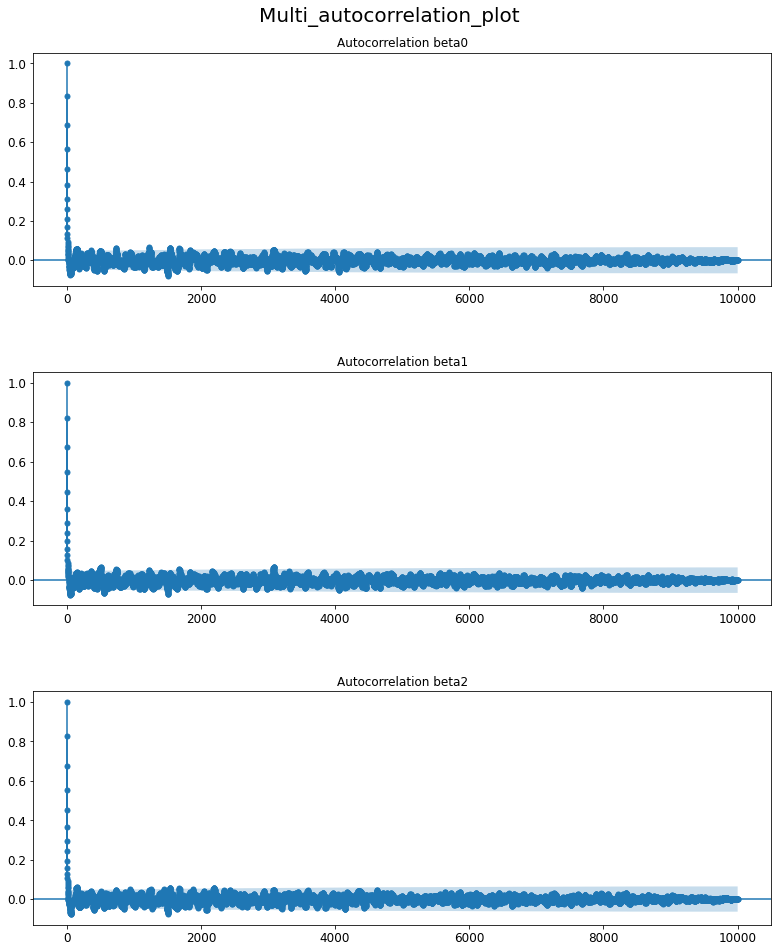

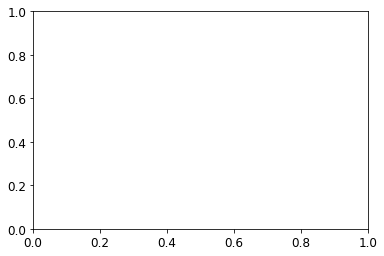

In [27]:
## AUTOCORRELATION PLOTS #################################################################
autocorrelation_plot = multi_plot_chain(betas_try, plot_autocorrelation, title = 'autocorrelation')
autocorrelation_plot.savefig('imgs/multi_autocorrelation_plot')
autocorrelation_plot
################################################################################

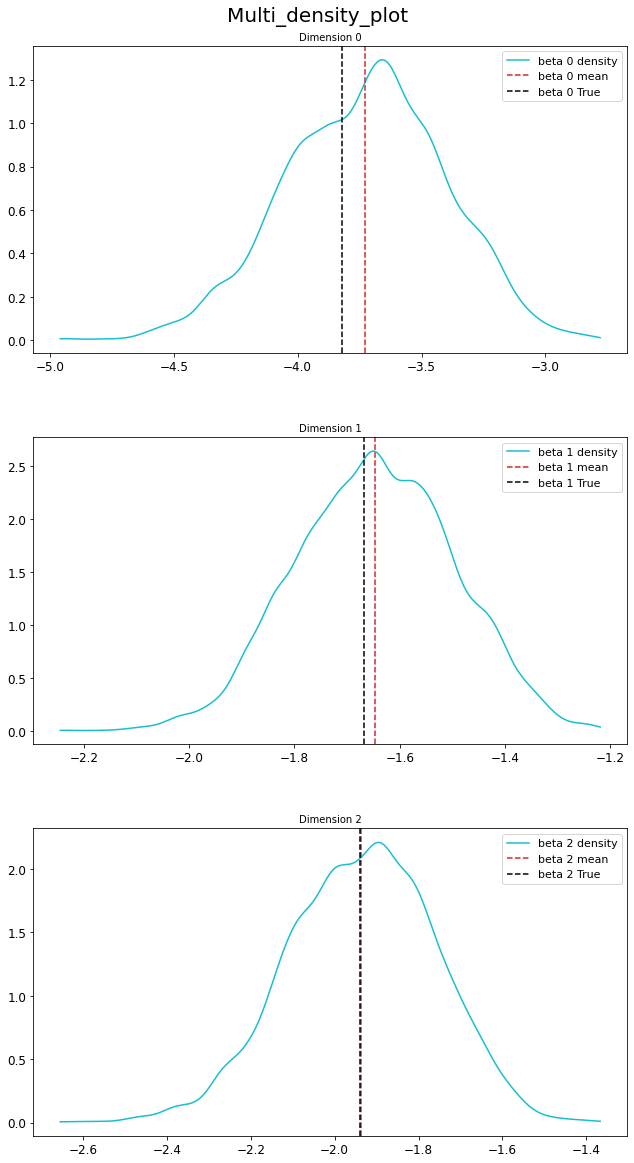

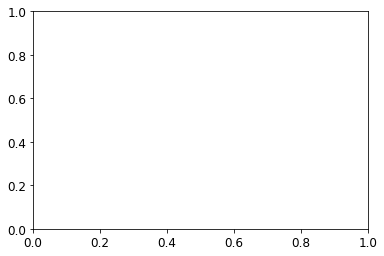

In [28]:
density_MH = multi_plot_chain(betas_try, plot_density_dimension, title = 'density', fig_size=(10,17))
density_MH.savefig('imgs/density_MH')
density_MH

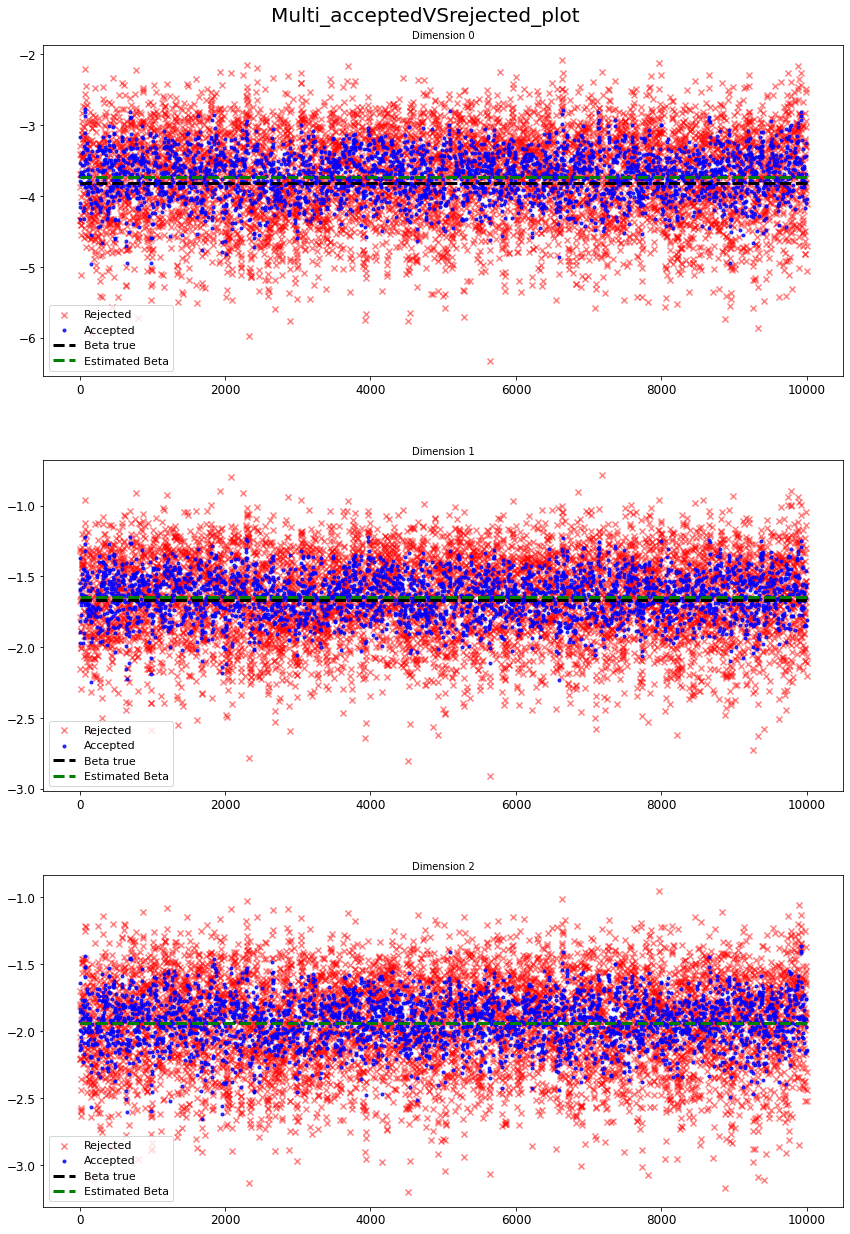

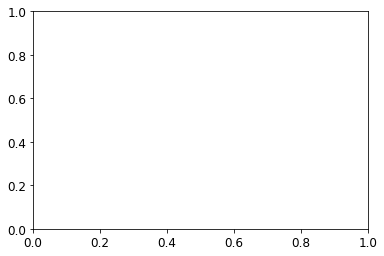

In [29]:
accepted_rejected = multi_plot_chain(betas_try,
                                     lambda theta, dimension, ax, plot_theta_true : plot_accepted_rejected(theta, dimension, ax, plot_theta_true, rejected = rejected, chain_rejected = acc_rej),
                                     title = 'acceptedVSrejected', plot_theta_true = True, fig_size=(13,18))
accepted_rejected.savefig('imgs/multiaccVSrejplot')
accepted_rejected

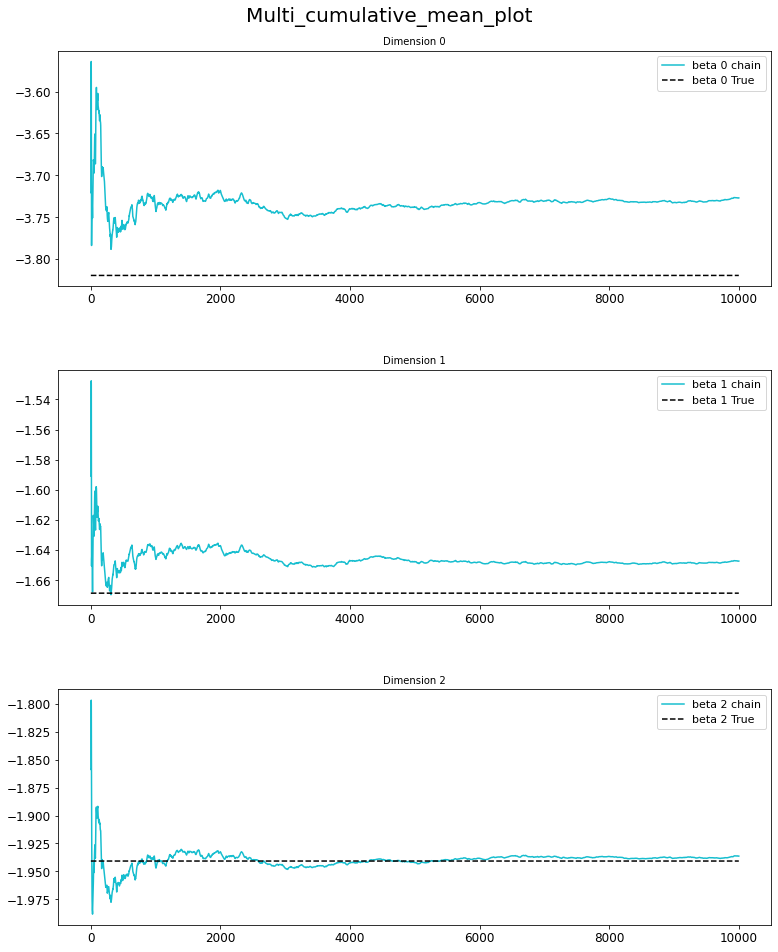

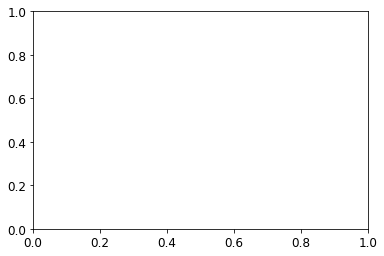

In [30]:
###### ATTEMPT PLOT CUMULATIVE AVERAGE ###########
# ideally after burn in beta at some dimension should present a constant over time average as the single expected 
cumulative_means_plot = multi_plot_chain(betas_try, plot_cumulative_mean, title = 'cumulative_mean')
cumulative_means_plot.savefig('imgs/cumulative_means_plot')
cumulative_means_plot

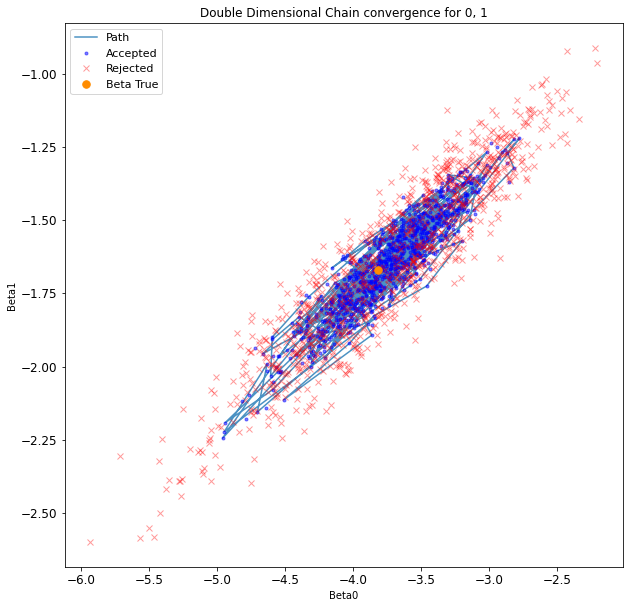

In [31]:
double_acc_rej_12 = plot_double_dim_accepted_rejected(betas_try, dimensions = (0,1), rejected = rejected, chain_rejected = acc_rej)
double_acc_rej_12.savefig('imgs/Double_dim_acc_rej_12')
double_acc_rej_12


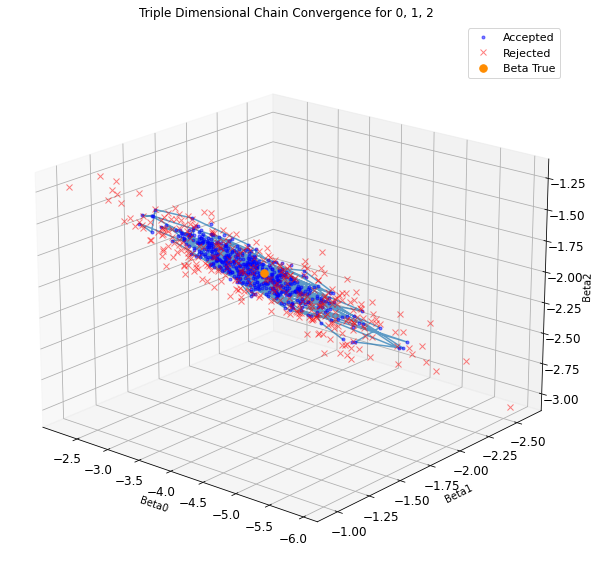

In [32]:
triple_acc_rej_012 = plot_triple_dim_accepted_rejected(betas_try, dimensions = (0,1,2), rejected = rejected, chain_rejected = acc_rej)
triple_acc_rej_012.savefig('imgs/Triple_dim_acc_rej_123')
# triple_acc_rej_012

### Auxiliary Gibbs

In [33]:
####### BEST CONFIGURATION VALUES GIBBS ALGORITHM ###############
beta_0 = np.zeros((p+1,1))
#beta_ols = np.dot(np.linalg.inv(np.dot(X.T,X)), np.dot(X.T,Y)) might be used
burnin_try = 1000
iterations_after_burnin_try = 10000
print('Starting beta', beta_0.flatten(), '\nBeta true:', beta_true.flatten())
##################################################

Starting beta [0. 0. 0.] 
Beta true: [-3.81943841 -1.66849063 -1.94069479]


In [34]:
#### RUNNING GIBBS SAMPLING ALGORITHM ##################################################
start_gibbs = time.time()
values, mean = Auxiliary_Gibbs_Sampling(beta_0, Y, X, burnin = burnin_try,
                                        iterations_after_burnin = iterations_after_burnin_try, prior = diffuse_full_conditional_beta)
end_gibbs = time.time()
print(f'Time elapsed: {end_gibbs - start_gibbs} seconds')
####################################################################################################

Computation starts
Reached 500 iterations of burn-in
Reached 1000 iterations of burn-in
Starting to run the ergodic chain...
Reached 500 iterations of the ergodic chain
Reached 1000 iterations of the ergodic chain
Reached 1500 iterations of the ergodic chain
Reached 2000 iterations of the ergodic chain
Reached 2500 iterations of the ergodic chain
Reached 3000 iterations of the ergodic chain
Reached 3500 iterations of the ergodic chain
Reached 4000 iterations of the ergodic chain
Reached 4500 iterations of the ergodic chain
Reached 5000 iterations of the ergodic chain
Reached 5500 iterations of the ergodic chain
Reached 6000 iterations of the ergodic chain
Reached 6500 iterations of the ergodic chain
Reached 7000 iterations of the ergodic chain
Reached 7500 iterations of the ergodic chain
Reached 8000 iterations of the ergodic chain
Reached 8500 iterations of the ergodic chain
Reached 9000 iterations of the ergodic chain
Reached 9500 iterations of the ergodic chain
Reached 10000 iterati

In [35]:
print('Resulting beta', mean.flatten(), '\n True Beta', beta_true.flatten())
print('Mean Square Error:', np.sum((mean.flatten() - beta_true.flatten()) ** 2) / beta_true.shape[0])
##################################################

Resulting beta [-3.78590966 -1.67558045 -1.96686011] 
 True Beta [-3.81943841 -1.66849063 -1.94069479]
Mean Square Error: 0.0006196890164416719


/var/folders/zq/w6pb52tx79585gtpznvcr45c0000gn/T/ipykernel_16879/1975968402.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "title" which is no longer supported as of 3.3 and will become an error two minor releases later
  multi_trace_plot.savefig('imgs/multi_trace_plot_gibbs', title = 'trace')


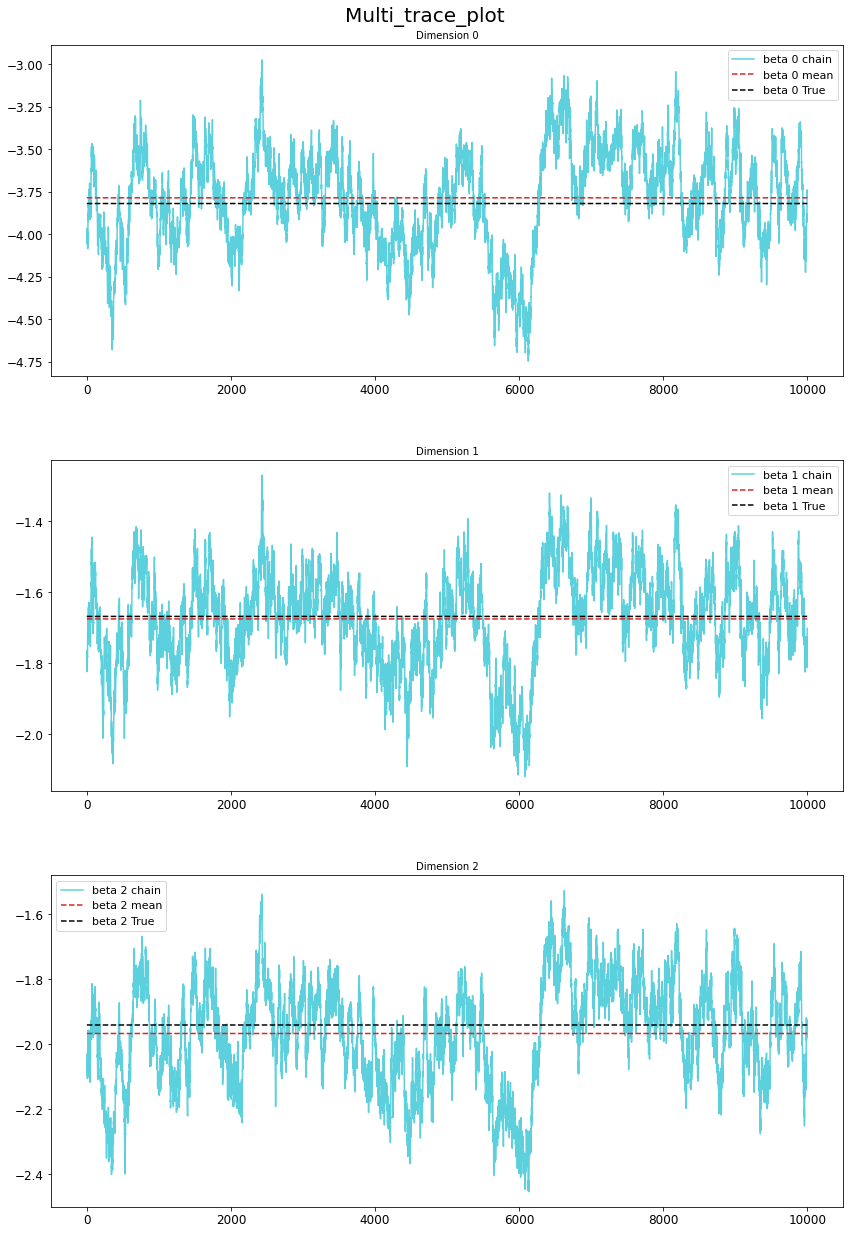

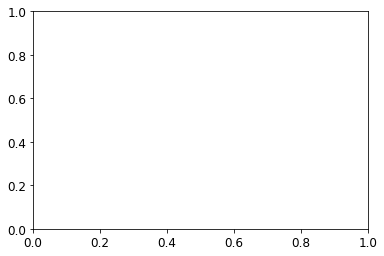

In [36]:
## TRACE PLOTS #################################################################
multi_trace_plot = multi_plot_chain(values, plot_trace_dimension, title = 'trace', fig_size=(13,18))
multi_trace_plot.savefig('imgs/multi_trace_plot_gibbs', title = 'trace')
multi_trace_plot
################################################################################

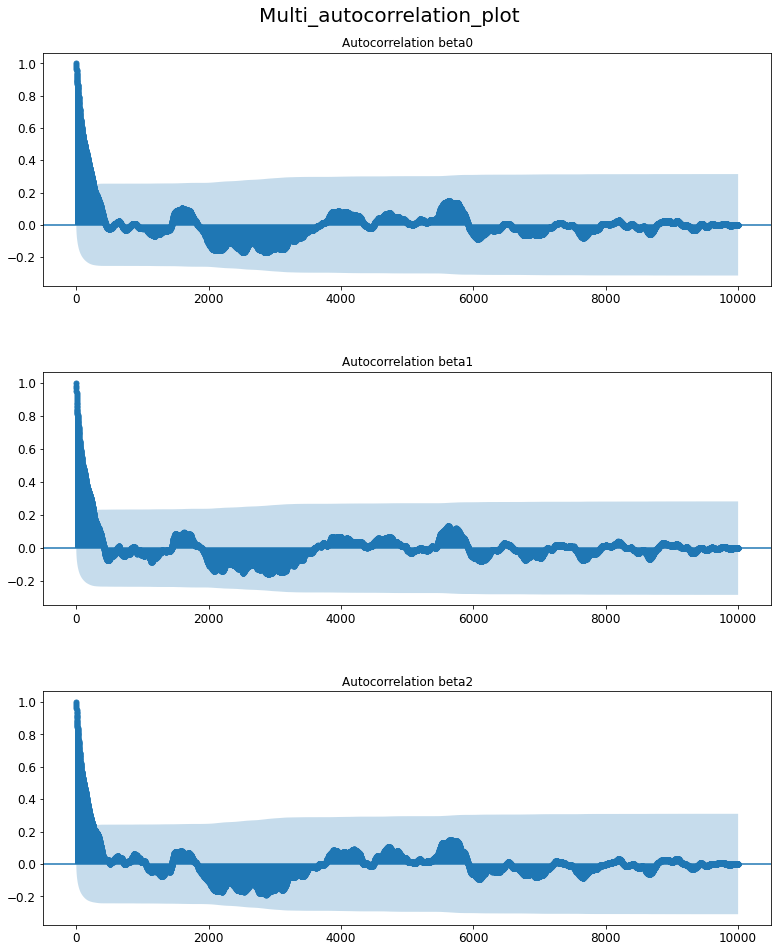

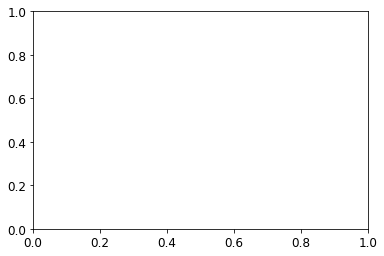

In [37]:
## AUTOCORRELATION PLOTS #################################################################
autocorrelation_plot = multi_plot_chain(values, plot_autocorrelation, title = 'autocorrelation')
autocorrelation_plot.savefig('imgs/multi_autocorrelation_plot_gibbs')
autocorrelation_plot
################################################################################

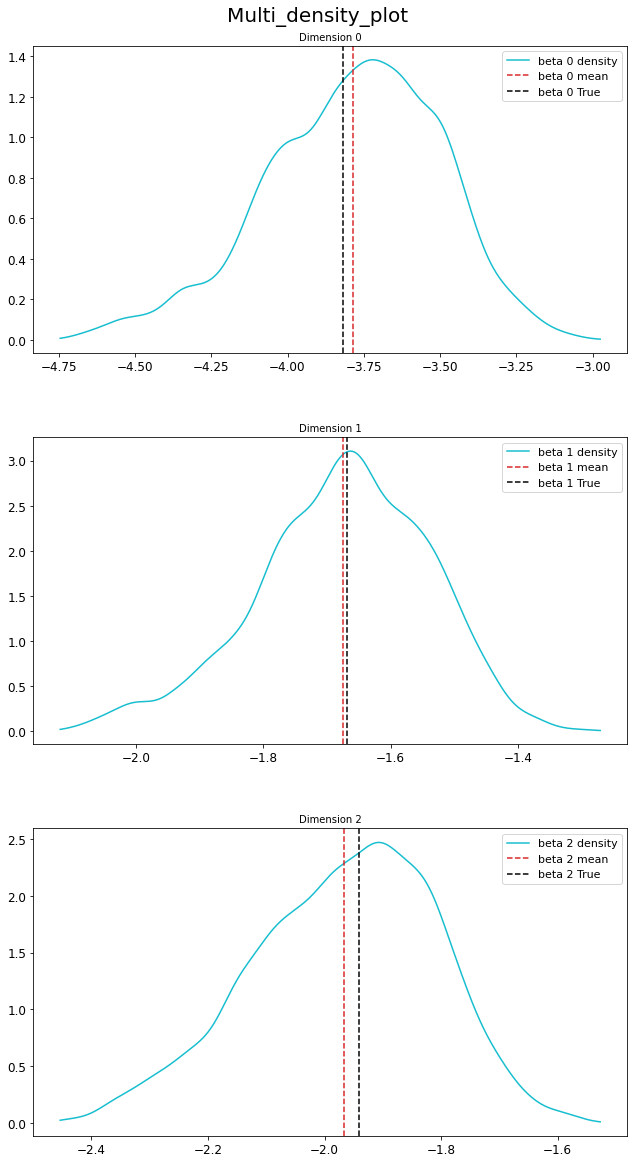

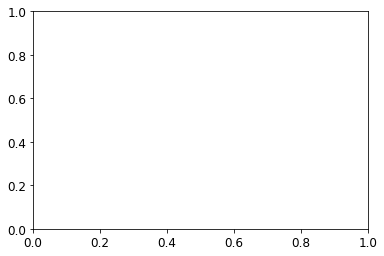

In [38]:
density_Gibbs = multi_plot_chain(values, plot_density_dimension, title = 'density', fig_size=(10,17))
density_Gibbs.savefig('imgs/density_Gibbs')
density_Gibbs

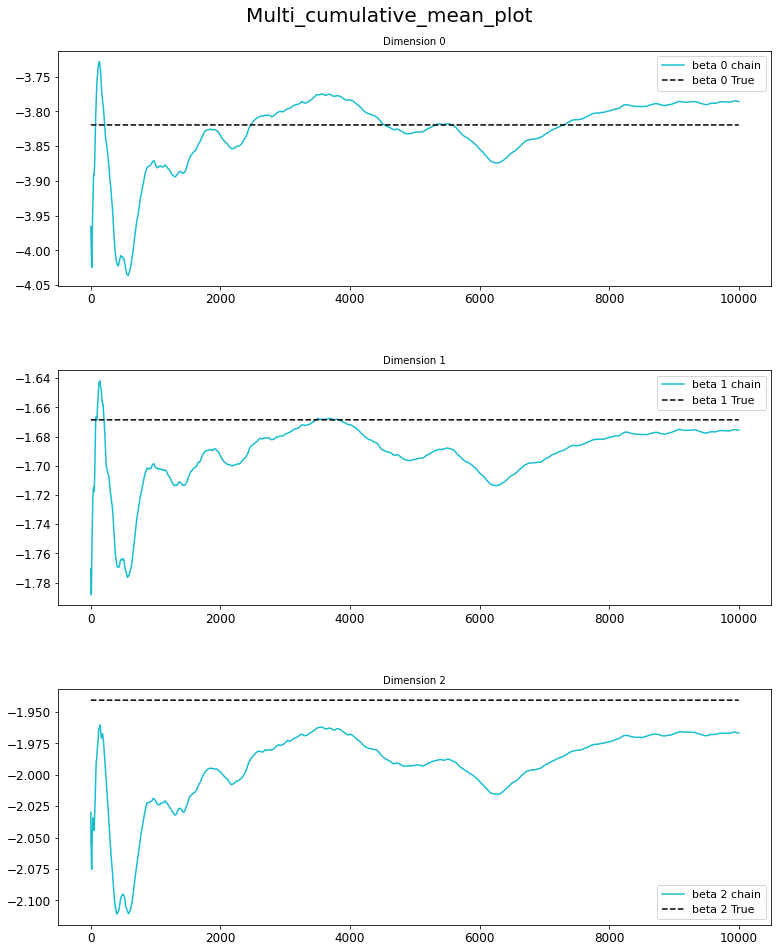

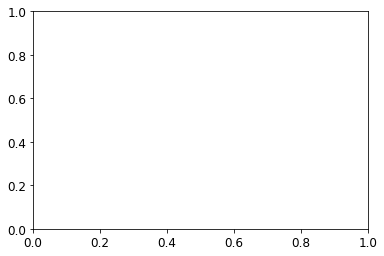

In [39]:
###### ATTEMPT PLOT CUMULATIVE AVERAGE ###########
# ideally after burn in beta at some dimension should present a constant over time average as the single expected 
cumulative_means_plot = multi_plot_chain(values, plot_cumulative_mean, title = 'cumulative_mean')
cumulative_means_plot.savefig('imgs/cumulative_means_plot_gibbs')
cumulative_means_plot

## Metropolis VS Gibbs Comparison

In [40]:
####### METROPOLIS/GIBBS COMPARISON ############################################

def metropolis_gibbs_plot(function, thetas_metropolis, thetas_gibbs, plot_theta_true=True, fig_size=(13,18)):
    dim = thetas_metropolis.shape[1]
    fig, ax = plt.subplots(dim, 2, figsize=fig_size)
    for i in range(dim):
        function(thetas_metropolis, dimension = i, ax = ax[i,0], plot_theta_true = plot_theta_true, title=False)
        function(thetas_gibbs, dimension = i, ax = ax[i,1], plot_theta_true = plot_theta_true, title=False)
        min_theta = min(thetas_metropolis[:,i].min(), thetas_gibbs[:,i].min())
        max_theta = max(thetas_metropolis[:,i].max(), thetas_gibbs[:,i].max())
        if function == plot_trace_dimension:
            ax[i,0].set_ylim(min_theta-thetas_metropolis[:,i].std()/5, max_theta+thetas_metropolis[:,i].std()/5)
            ax[i,1].set_ylim(min_theta-thetas_metropolis[:,i].std()/5, max_theta+thetas_metropolis[:,i].std()/5)
    ax[0,0].title.set_text('Metropolis Hastings')
    ax[0,1].title.set_text('Auxiliary Gibbs')
    if function==plot_cumulative_mean:
        fig.suptitle('Cumulative Mean comparison', size=20)
    elif function==plot_trace_dimension:
        fig.suptitle('Trace plots comparison', size=20)
    elif function==plot_density_dimension:
        fig.suptitle('Empirical Desnity comparison', size=20)
    else:
        fig.suptitle('Autocorrelation comparison', size=20)
    plt.subplots_adjust(top=.95)
    plt.close(fig)
    return fig


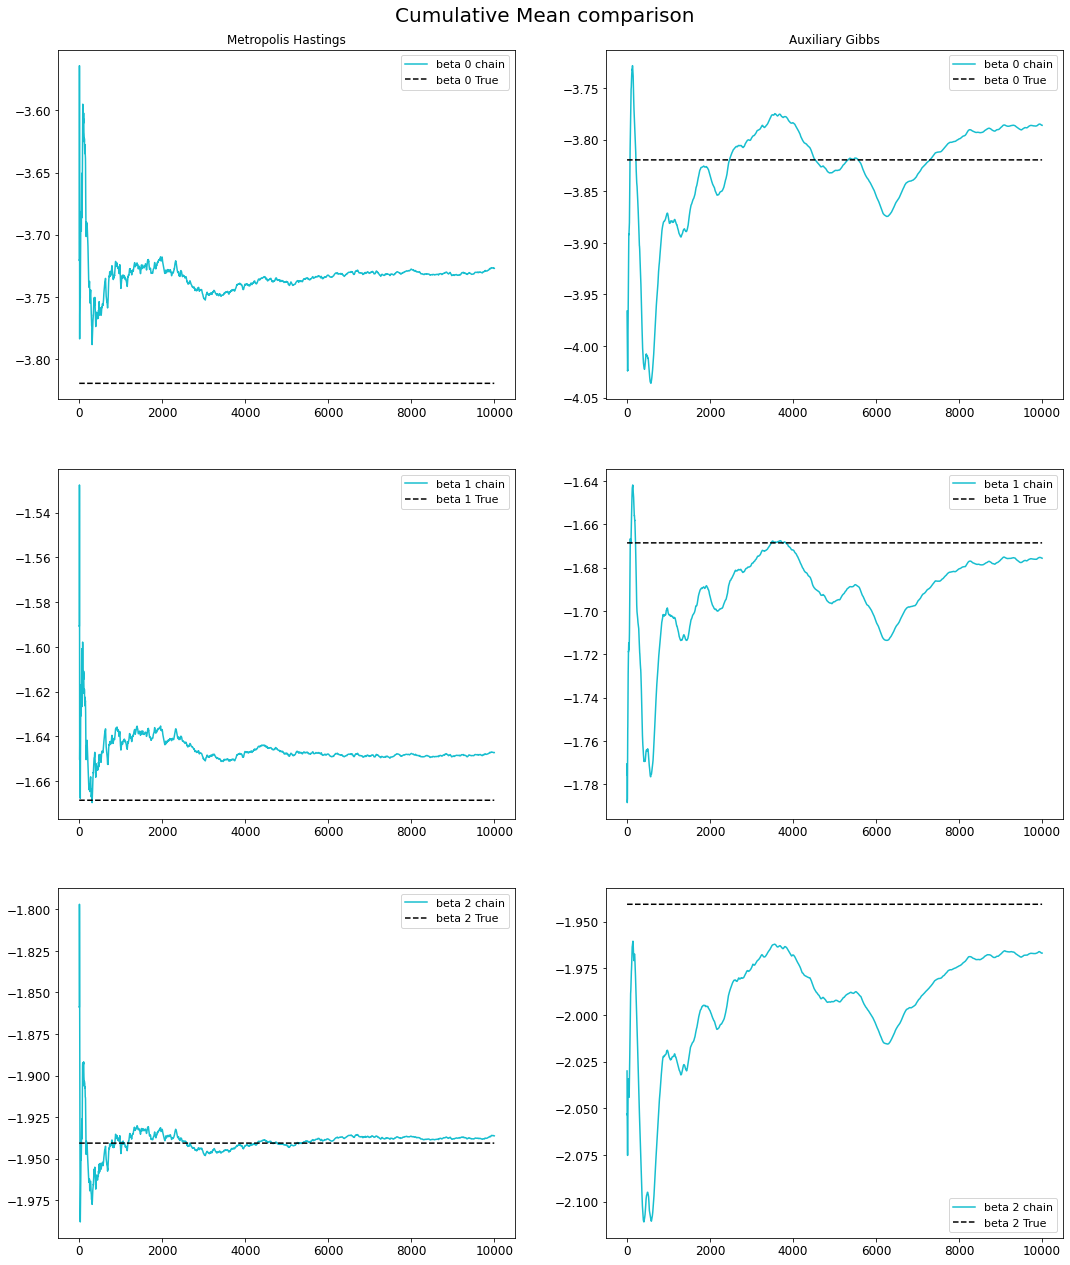

In [41]:
comp_mean = metropolis_gibbs_plot(function=plot_cumulative_mean, thetas_metropolis=betas_try, thetas_gibbs=values, plot_theta_true=True, fig_size=(18,20))
comp_mean.savefig('imgs/cumulative_mean_comp')
comp_mean

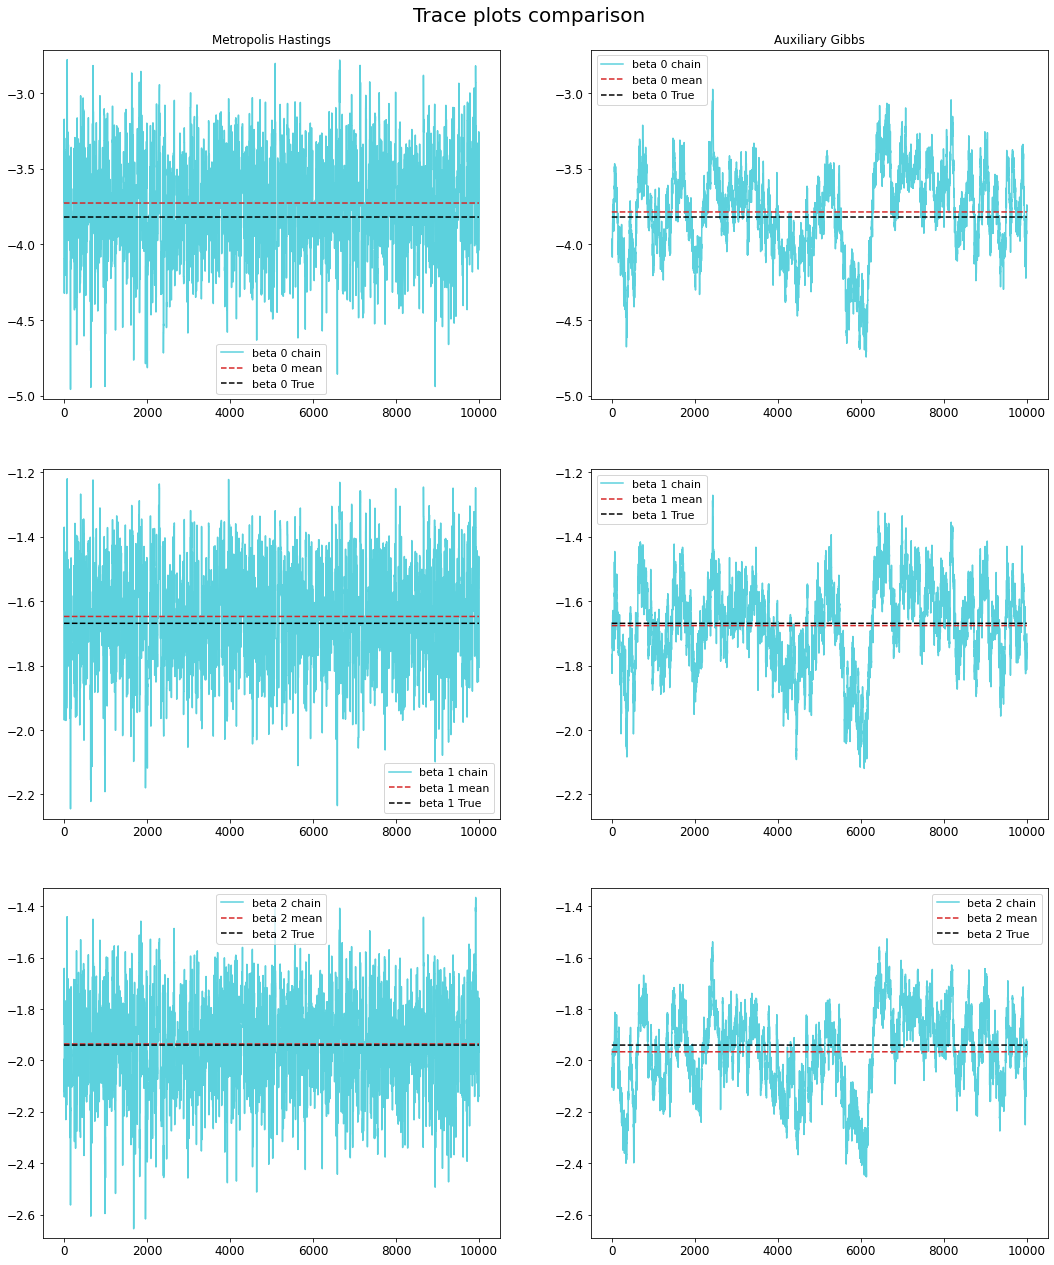

In [42]:
comp_trace = metropolis_gibbs_plot(function=plot_trace_dimension, thetas_metropolis=betas_try, thetas_gibbs=values, plot_theta_true=True, fig_size=(18,20))
comp_trace.savefig('imgs/trace_comp')
comp_trace

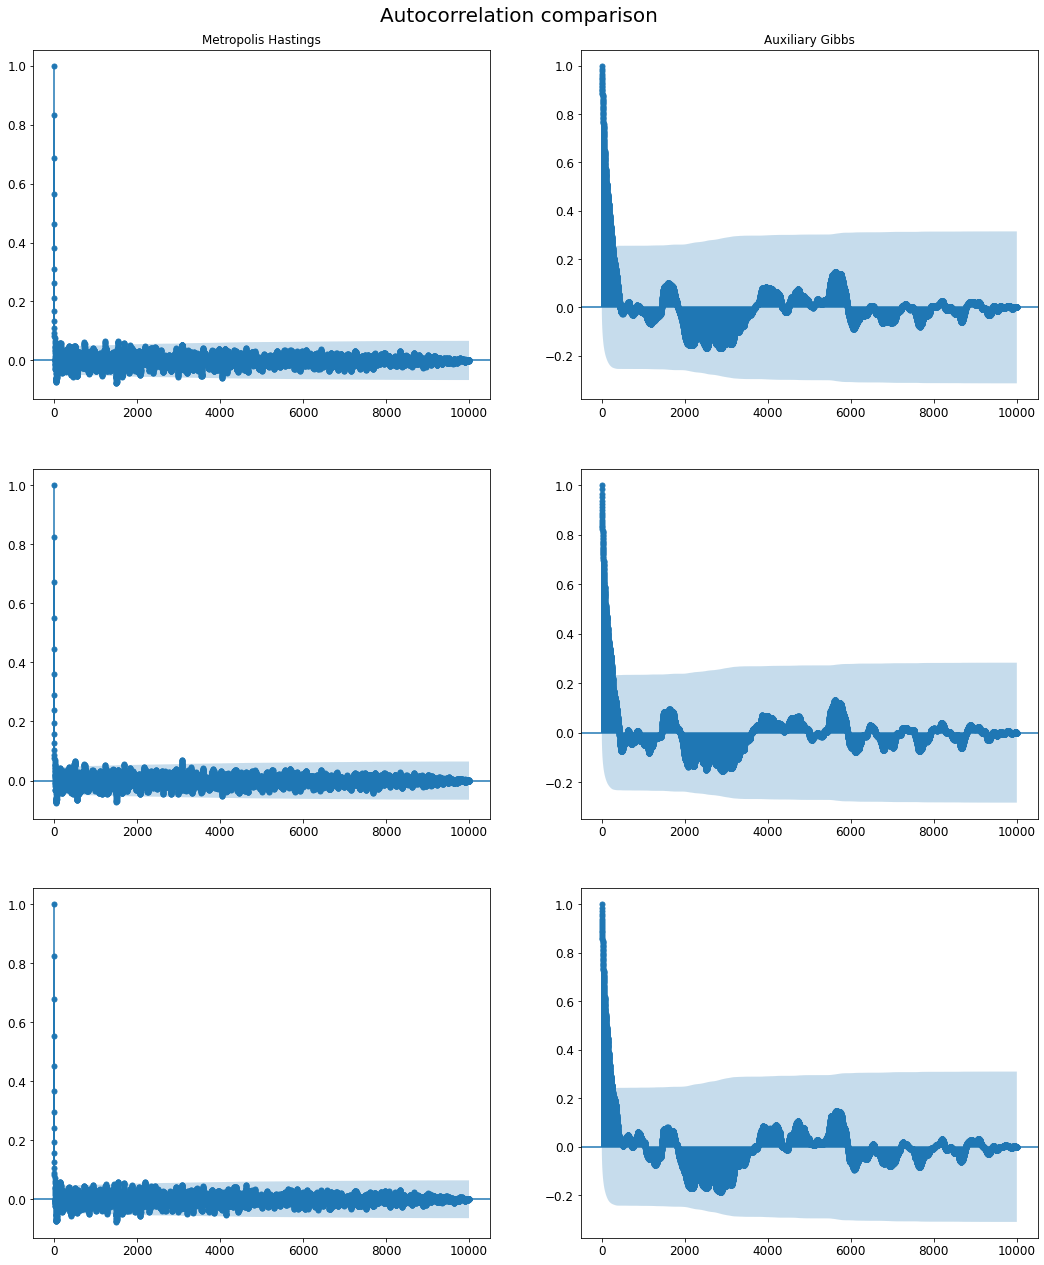

In [43]:
comp_autocorr = metropolis_gibbs_plot(function=plot_autocorrelation, thetas_metropolis=betas_try, thetas_gibbs=values, plot_theta_true=True, fig_size=(18,20))
comp_autocorr.savefig('imgs/autocorrelation_comp')
comp_autocorr

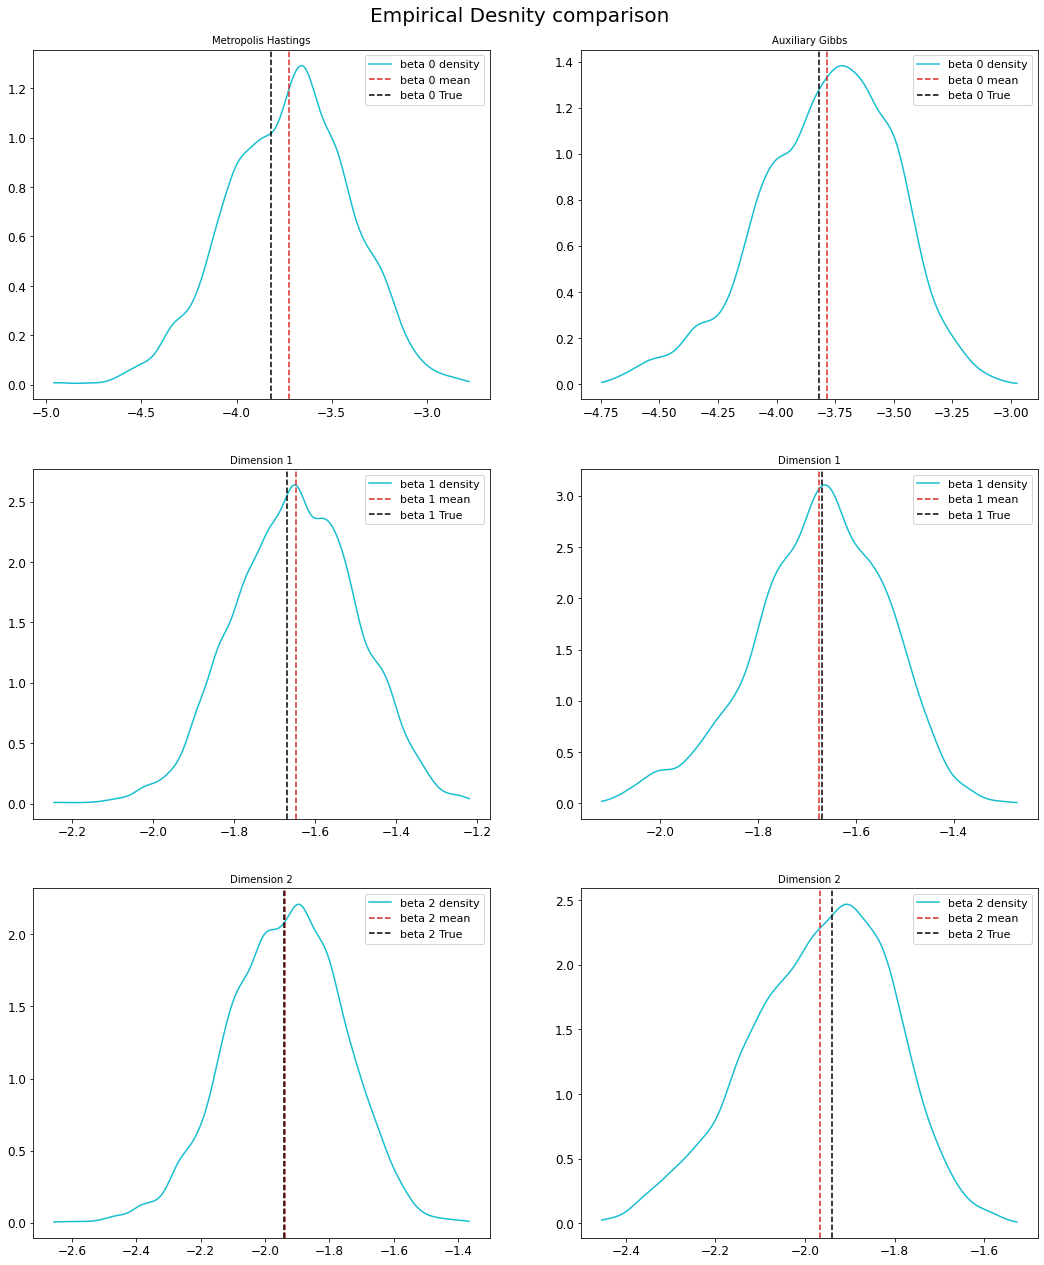

In [44]:
comp_density = metropolis_gibbs_plot(function=plot_density_dimension, thetas_metropolis=betas_try, thetas_gibbs=values, plot_theta_true=True, fig_size=(18,20))
comp_density.savefig('imgs/density_comp')
comp_density

In [45]:
beta_true.flatten()

array([-3.81943841, -1.66849063, -1.94069479])

## Dataset Analysis

In [46]:
import pandas as pd
from statsmodels.discrete.discrete_model import Probit


In [47]:
df = pd.read_csv("predictive_maintenance.csv")

In [48]:
regressors = df[['Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]']].to_numpy()
regressors = np.hstack((np.ones((regressors.shape[0] , 1), dtype = int), regressors))
outcome = df['Target'].to_numpy().reshape((df.shape[0], 1))

In [49]:
regressors.shape

(10000, 6)

In [50]:
###MLE estimation
from statsmodels.discrete.discrete_model import Probit
try:
    probit_MLE_df = Probit(outcome, regressors)
    result_MLE_df = probit_MLE_df.fit()
    print(result_MLE_df.summary())
    beta_MLE_df = result_MLE_df.params
    Var_df_MLE = result_MLE_df.cov_params()
    beta_df_MLE = beta_MLE_df.flatten()
    found_MLE = True
except:
    found_MLE = False

Optimization terminated successfully.
         Current function value: 0.097573
         Iterations 9
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                         Probit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            5
Date:                Thu, 20 Jan 2022   Pseudo R-squ.:                  0.3409
Time:                        13:33:02   Log-Likelihood:                -975.73
converged:                       True   LL-Null:                       -1480.5
Covariance Type:            nonrobust   LLR p-value:                5.282e-216
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.4486      7.061     -2.471      0.013     -31.287      -3.610
x1             0.3838      0.

In [51]:
print(beta_df_MLE)

[-1.74486445e+01  3.83775760e-01 -3.68822608e-01  5.36084915e-03
  1.30759222e-01  6.42723654e-03]


In [52]:
### Setting our parameters
p = regressors.shape[1]
tau_df = 2
beta_0_df = np.zeros((p,1))
burnin_df = 1000
after_burnin_df = 5000

In [53]:
np.random.seed(2122234)

In [54]:
thetas_gibbs, mean_gibbs = Auxiliary_Gibbs_Sampling(beta_0_df, outcome, regressors, burnin = burnin_df,
                                        iterations_after_burnin = after_burnin_df, prior = diffuse_full_conditional_beta)

Computation starts
Reached 500 iterations of burn-in
Reached 1000 iterations of burn-in
Starting to run the ergodic chain...
Reached 500 iterations of the ergodic chain
Reached 1000 iterations of the ergodic chain
Reached 1500 iterations of the ergodic chain
Reached 2000 iterations of the ergodic chain
Reached 2500 iterations of the ergodic chain
Reached 3000 iterations of the ergodic chain
Reached 3500 iterations of the ergodic chain
Reached 4000 iterations of the ergodic chain
Reached 4500 iterations of the ergodic chain
Reached 5000 iterations of the ergodic chain
Iterations terminated
Mean at termination: [-1.74548380e+01  3.80553494e-01 -3.65655057e-01  5.35699584e-03
  1.30678095e-01  6.43280214e-03]


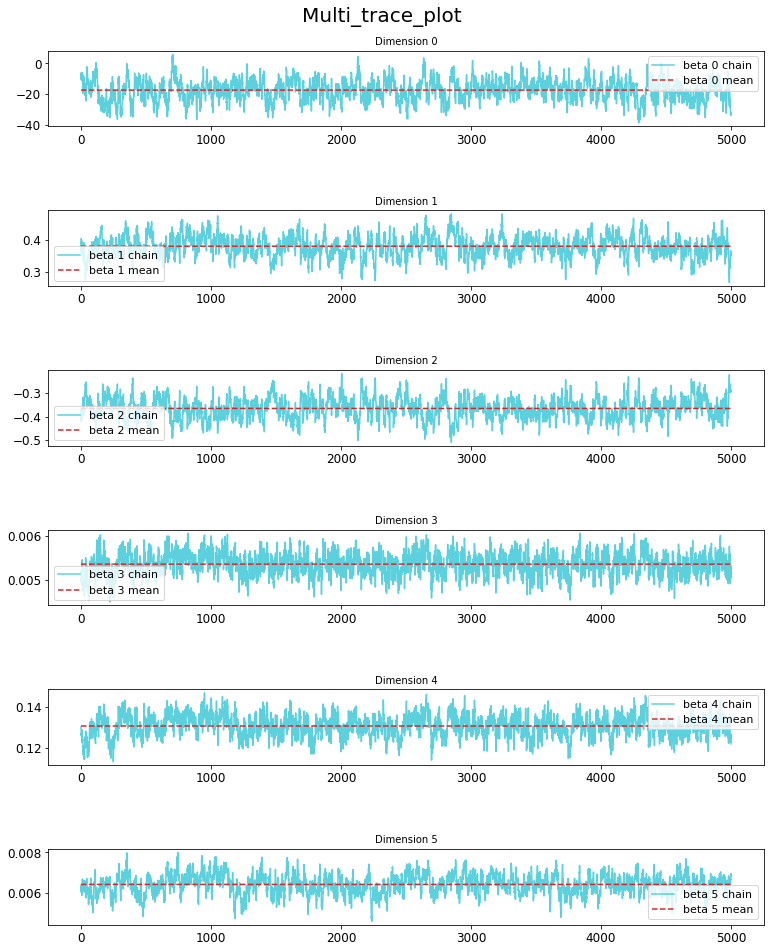

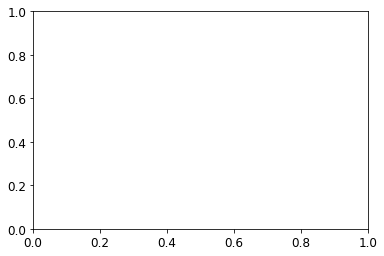

In [55]:
multi_plot_chain(thetas_gibbs, plot_trace_dimension, title = 'trace', plot_theta_true= False)

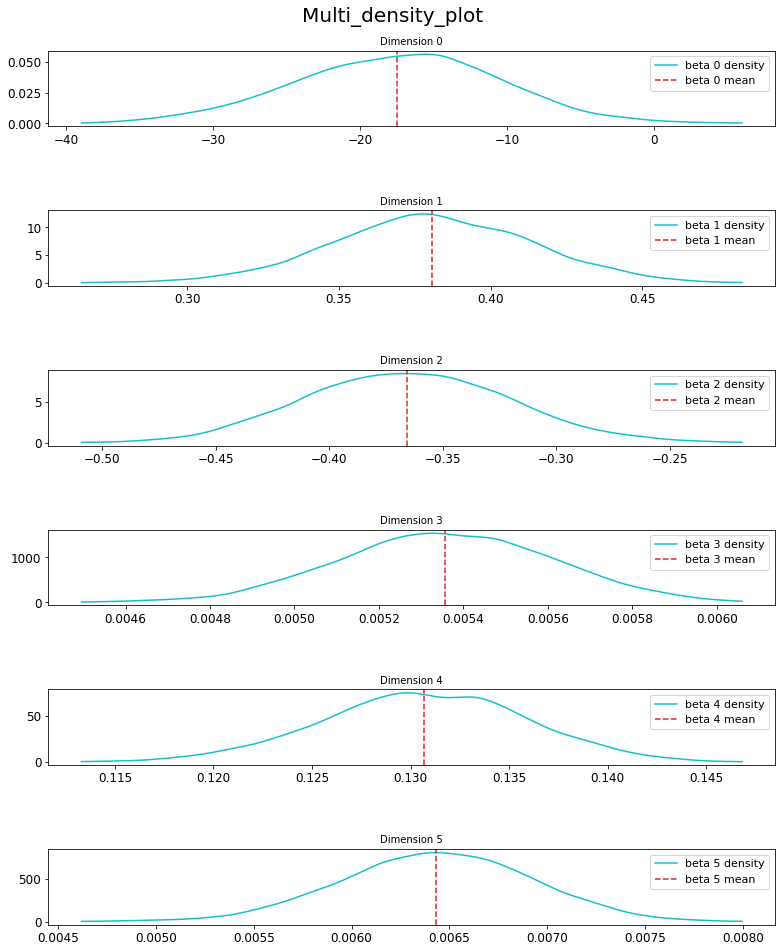

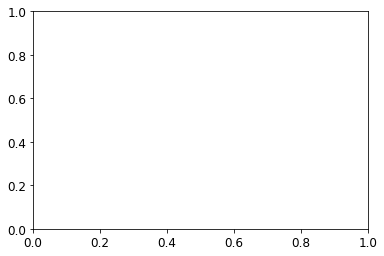

In [56]:
multi_plot_chain(thetas_gibbs, plot_density_dimension, title = 'density', plot_theta_true=False)

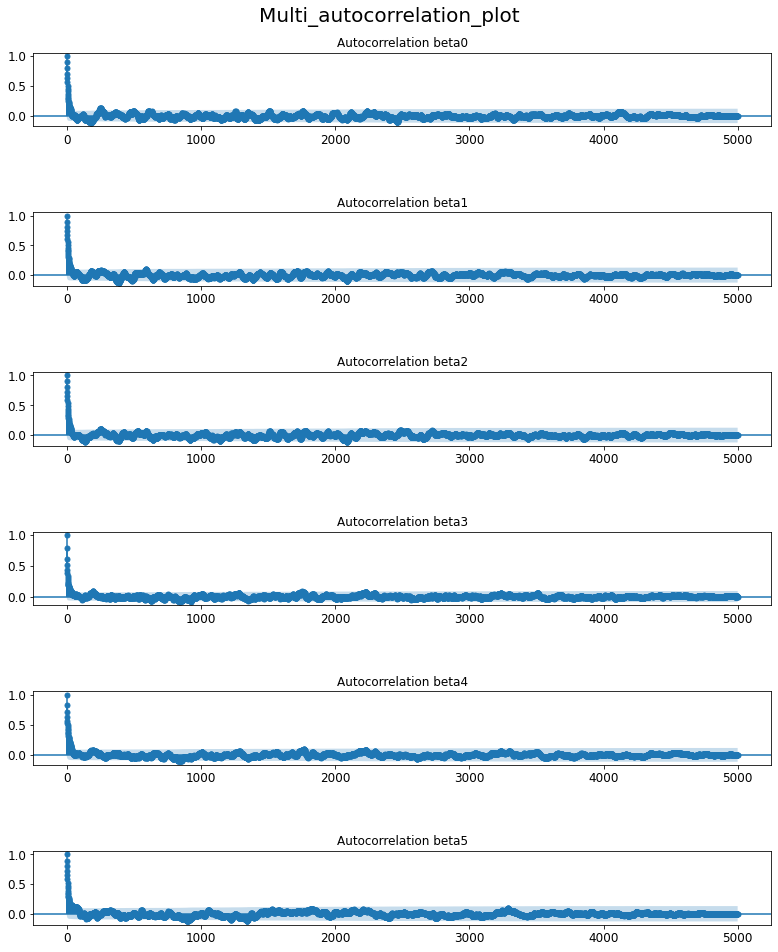

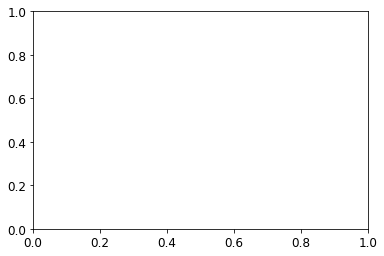

In [57]:
multi_plot_chain(thetas_gibbs, plot_autocorrelation, title = 'autocorrelation')

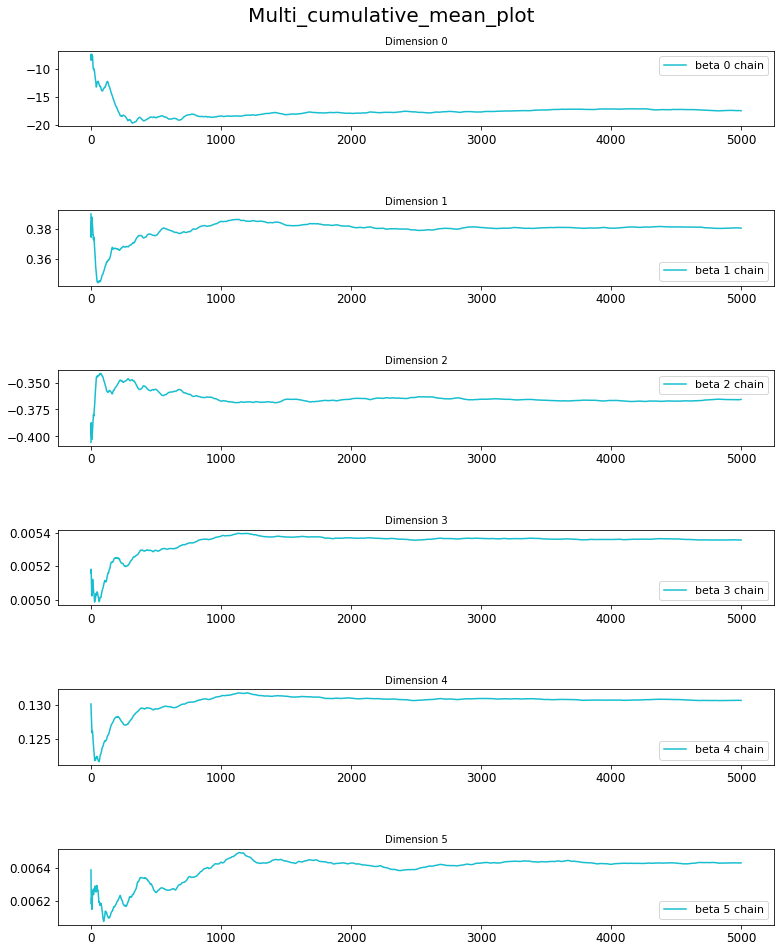

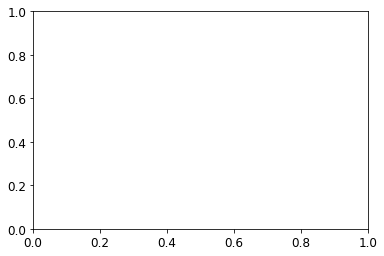

In [58]:
multi_plot_chain(thetas_gibbs, plot_cumulative_mean, title = 'cumulative_mean', plot_theta_true= False)

In [59]:
np.random.seed(1011234)

In [60]:
thetas_random_walk, mean_random_walk, rejected, acc_rej = MetropolisAlgorithm(outcome, regressors, beta_0_df, 
                                                                   tau_df, burnin = burnin_df, 
                                                                   iterations_after_burnin = after_burnin_df, 
                                                                   log=True, prior = prior_uninformative )

Computation starts
Reached 500 iterations of burn-in, so far 145 values were accepted. 
Acceptance proportion is 0.29

Reached 1000 iterations of burn-in, so far 204 values were accepted. 
Acceptance proportion is 0.2

Starting to run the ergodic chain...
Reached 500 iterations of the ergodic chain
Reached 1000 iterations of the ergodic chain
Reached 1500 iterations of the ergodic chain
Reached 2000 iterations of the ergodic chain
Reached 2500 iterations of the ergodic chain
Reached 3000 iterations of the ergodic chain
Reached 3500 iterations of the ergodic chain
Reached 4000 iterations of the ergodic chain
Reached 4500 iterations of the ergodic chain
Reached 5000 iterations of the ergodic chain
Iterations terminated
Mean at termination: [-1.73883181e+01  3.84978378e-01 -3.70305644e-01  5.37726166e-03
  1.30988407e-01  6.44863176e-03]


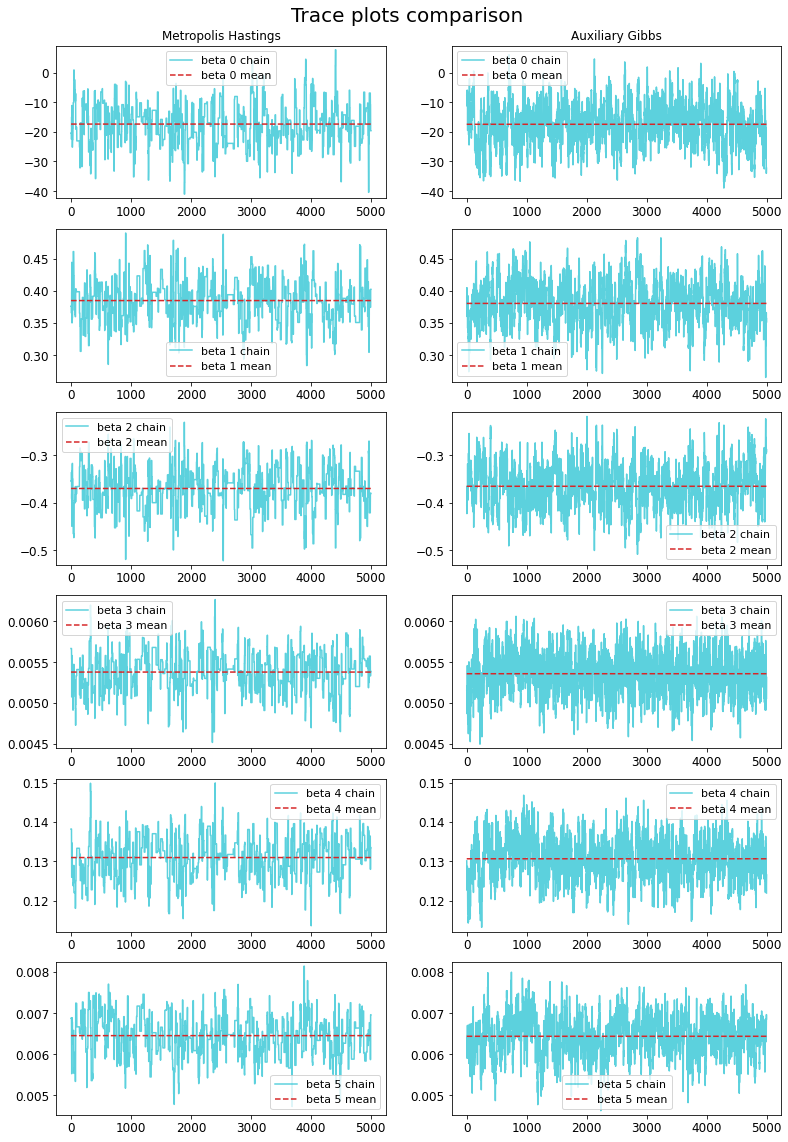

In [61]:
metropolis_gibbs_plot(function=plot_trace_dimension, thetas_metropolis=thetas_random_walk, thetas_gibbs=thetas_gibbs, plot_theta_true=False)

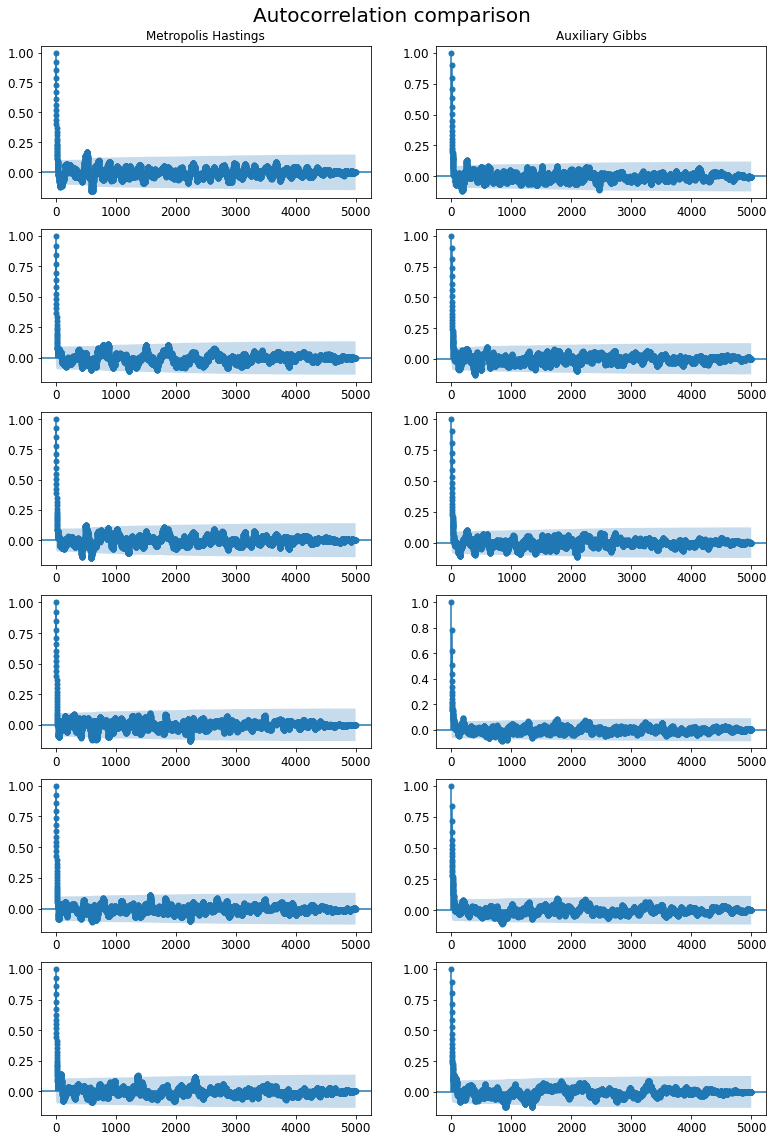

In [62]:
metropolis_gibbs_plot(function=plot_autocorrelation, thetas_metropolis=thetas_random_walk, thetas_gibbs=thetas_gibbs, plot_theta_true=False)

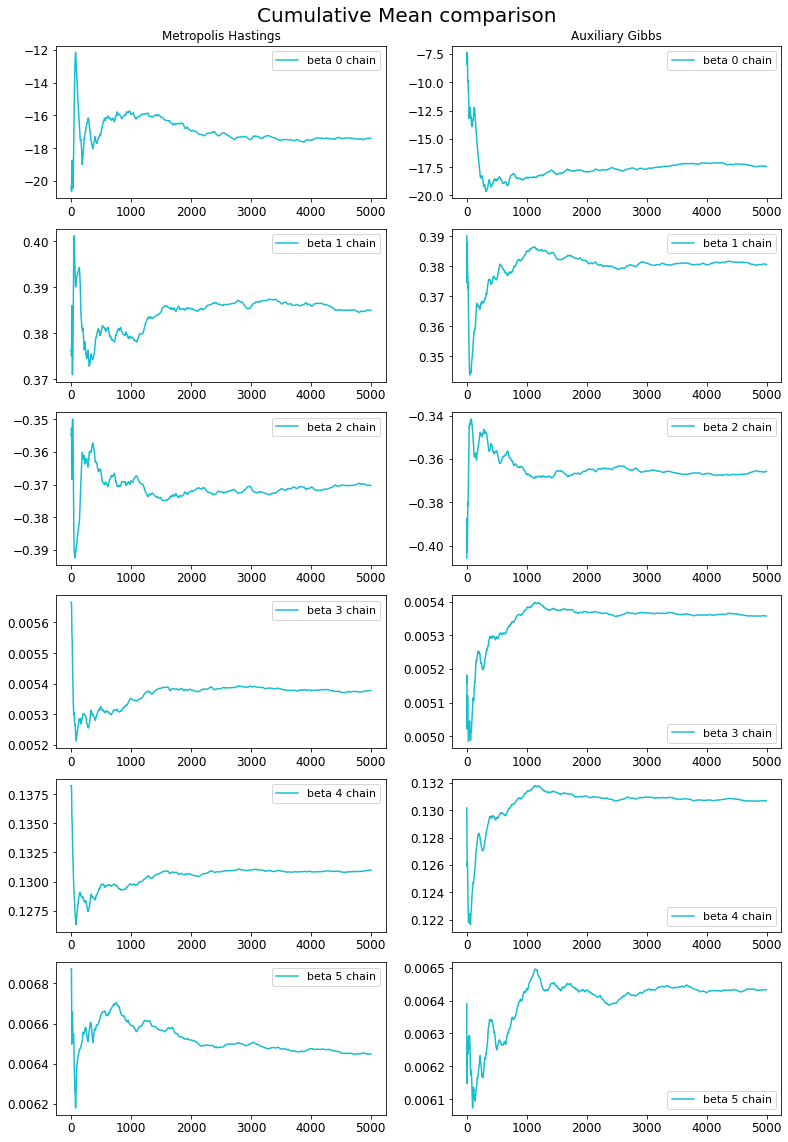

In [63]:
metropolis_gibbs_plot(function=plot_cumulative_mean, thetas_metropolis=thetas_random_walk, thetas_gibbs=thetas_gibbs, plot_theta_true=False)

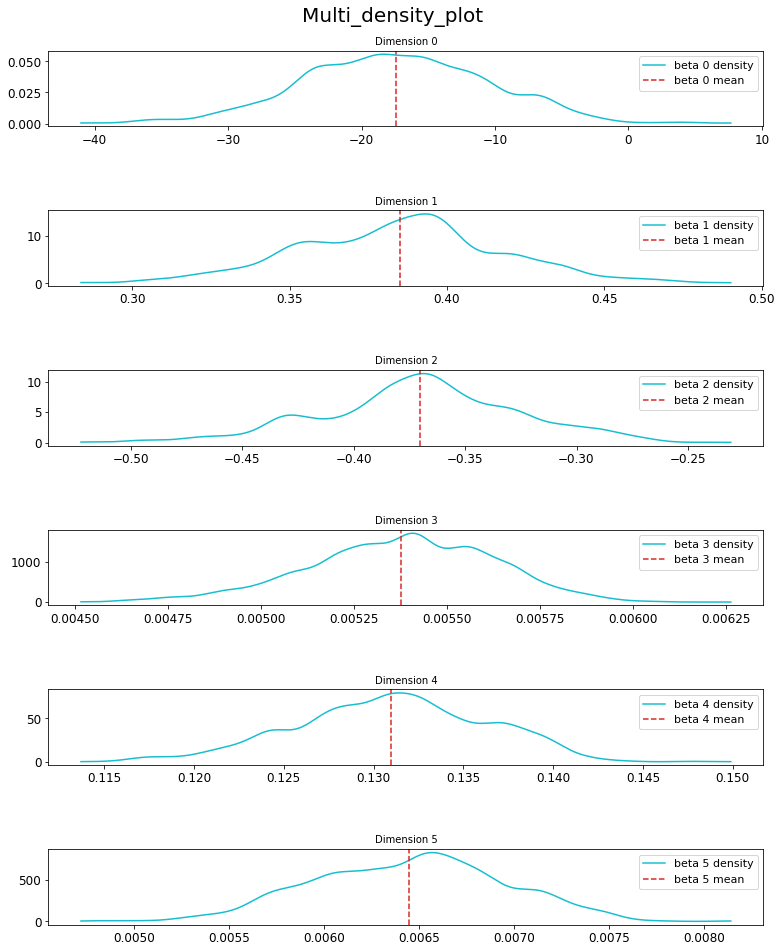

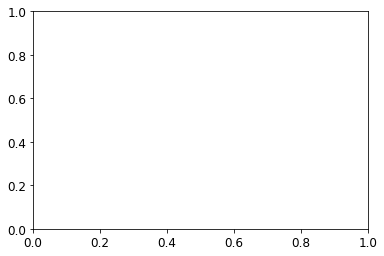

In [64]:
multi_plot_chain(thetas_random_walk, plot_density_dimension, title = 'density', plot_theta_true=False)

## Dataset 1000 observations

In [65]:
df_2 = df[['Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target']].iloc[:1000,]

In [66]:
df_2.Target.value_counts()

0    977
1     23
Name: Target, dtype: int64

In [67]:
regressors_2 = df_2[['Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]']].to_numpy()
regressors_2 = np.hstack((np.ones((regressors_2.shape[0] , 1), dtype = int), regressors_2))
outcome_2 = df_2['Target'].to_numpy().reshape((df_2.shape[0], 1))
burnin_df_2 = 1000
after_burnin_df_2 = 5000

In [68]:
####### RUNNING METROPOLIS ALGORITHM ###############
print('We are running starting from {}, with as variance factor tau = {}\n'.format(beta_0_df.flatten(), tau_df))
print('As Burn-in we will iterate {} times and collect a sample of a hopefully stationary ergodic distribution of dimension {}\n'.format(burnin_df, after_burnin_df))
thetas_random_walk_2, mean_random_walk_2, rejected_2, acc_rej_2 = MetropolisAlgorithm(outcome_2, regressors_2, beta_0_df, 
                                                                   tau_df, burnin = burnin_df_2, 
                                                                   iterations_after_burnin = after_burnin_df_2, 
                                                                   log=True, prior = prior_uninformative )
##################################################

We are running starting from [0. 0. 0. 0. 0. 0.], with as variance factor tau = 2

As Burn-in we will iterate 1000 times and collect a sample of a hopefully stationary ergodic distribution of dimension 5000

Computation starts
Reached 500 iterations of burn-in, so far 109 values were accepted. 
Acceptance proportion is 0.22

Reached 1000 iterations of burn-in, so far 179 values were accepted. 
Acceptance proportion is 0.18

Starting to run the ergodic chain...
Reached 500 iterations of the ergodic chain
Reached 1000 iterations of the ergodic chain
Reached 1500 iterations of the ergodic chain
Reached 2000 iterations of the ergodic chain
Reached 2500 iterations of the ergodic chain
Reached 3000 iterations of the ergodic chain
Reached 3500 iterations of the ergodic chain
Reached 4000 iterations of the ergodic chain
Reached 4500 iterations of the ergodic chain
Reached 5000 iterations of the ergodic chain
Iterations terminated
Mean at termination: [-8.43430507e+01  1.02206445e+00 -8.8847616

In [69]:
thetas_gibbs_2, mean_gibbs_2 = Auxiliary_Gibbs_Sampling(beta_0_df, outcome_2, regressors_2, burnin = burnin_df_2,
                                        iterations_after_burnin = after_burnin_df_2, 
                                        prior = diffuse_full_conditional_beta)

Computation starts
Reached 500 iterations of burn-in
Reached 1000 iterations of burn-in
Starting to run the ergodic chain...
Reached 500 iterations of the ergodic chain
Reached 1000 iterations of the ergodic chain
Reached 1500 iterations of the ergodic chain
Reached 2000 iterations of the ergodic chain
Reached 2500 iterations of the ergodic chain
Reached 3000 iterations of the ergodic chain
Reached 3500 iterations of the ergodic chain
Reached 4000 iterations of the ergodic chain
Reached 4500 iterations of the ergodic chain
Reached 5000 iterations of the ergodic chain
Iterations terminated
Mean at termination: [-9.37372542e+01  1.04420659e+00 -8.78047283e-01  1.92298555e-02
  4.03506021e-01  2.30510965e-02]


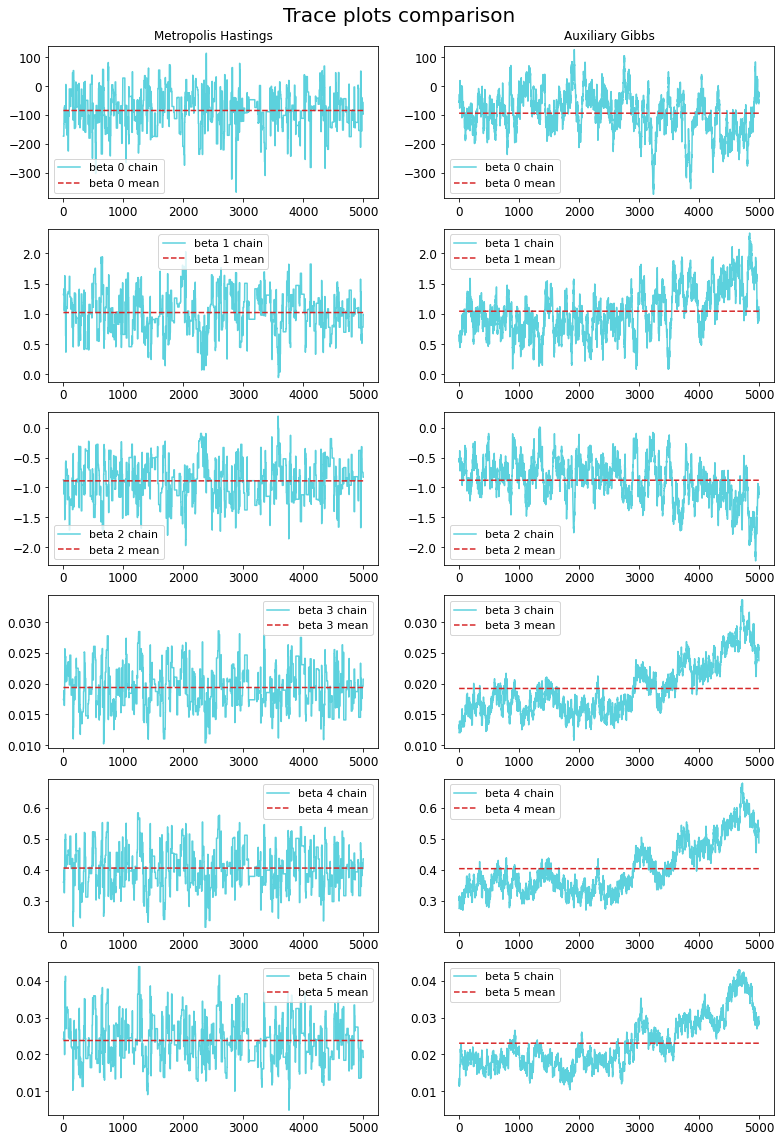

In [70]:
metropolis_gibbs_plot(function=plot_trace_dimension, thetas_metropolis=thetas_random_walk_2, thetas_gibbs=thetas_gibbs_2, plot_theta_true=False)

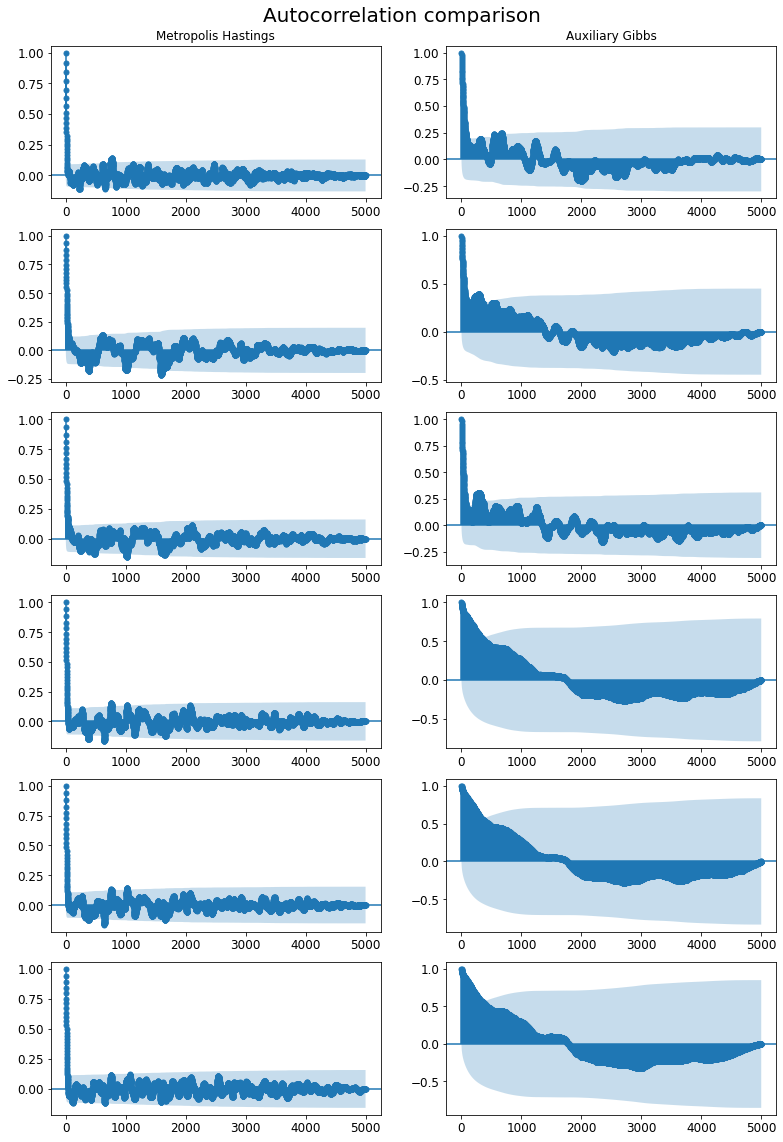

In [71]:
metropolis_gibbs_plot(function=plot_autocorrelation, thetas_metropolis=thetas_random_walk_2, thetas_gibbs=thetas_gibbs_2, plot_theta_true=False)

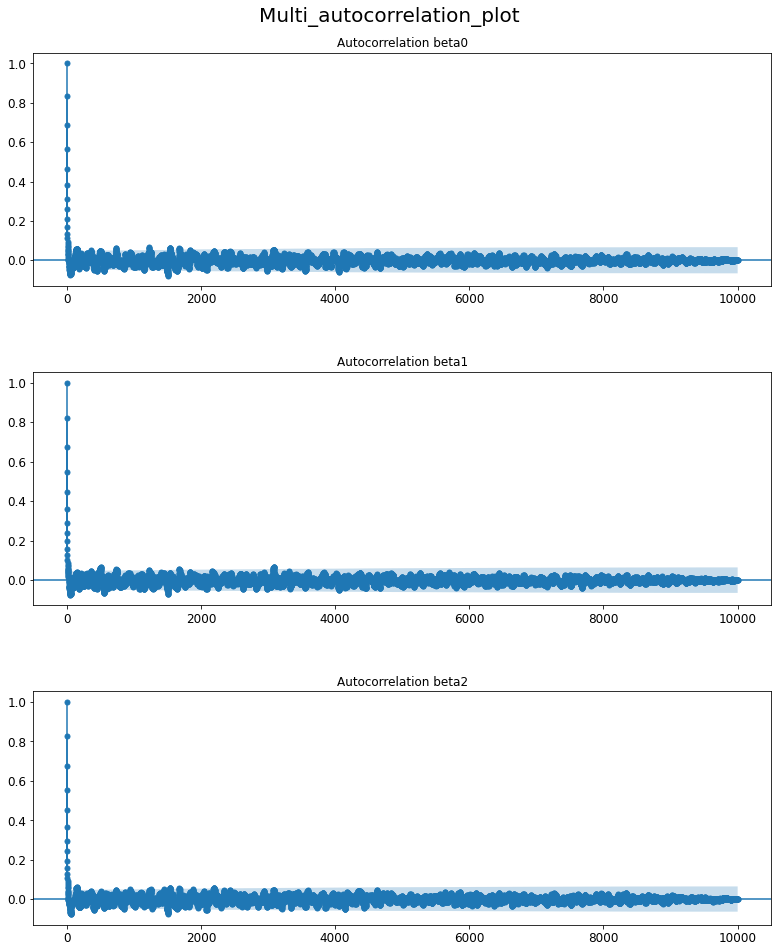

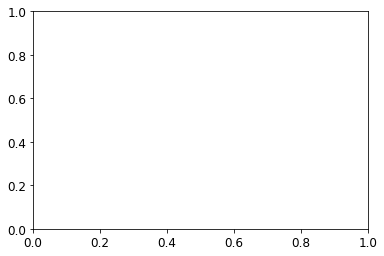

In [72]:
multi_plot_chain(betas_try, plot_autocorrelation, title = 'autocorrelation')

In [73]:
values_, mean_ = Auxiliary_Gibbs_Sampling(beta_0_df, outcome_2, regressors_2, burnin = burnin_df_2,
                                        iterations_after_burnin = after_burnin_df_2, 
                                        prior = diffuse_full_conditional_beta)

Computation starts
Reached 500 iterations of burn-in
Reached 1000 iterations of burn-in
Starting to run the ergodic chain...
Reached 500 iterations of the ergodic chain
Reached 1000 iterations of the ergodic chain
Reached 1500 iterations of the ergodic chain
Reached 2000 iterations of the ergodic chain
Reached 2500 iterations of the ergodic chain
Reached 3000 iterations of the ergodic chain
Reached 3500 iterations of the ergodic chain
Reached 4000 iterations of the ergodic chain
Reached 4500 iterations of the ergodic chain
Reached 5000 iterations of the ergodic chain
Iterations terminated
Mean at termination: [-1.01140357e+02  1.06678474e+00 -8.77675777e-01  1.94016602e-02
  4.07676061e-01  2.36826702e-02]


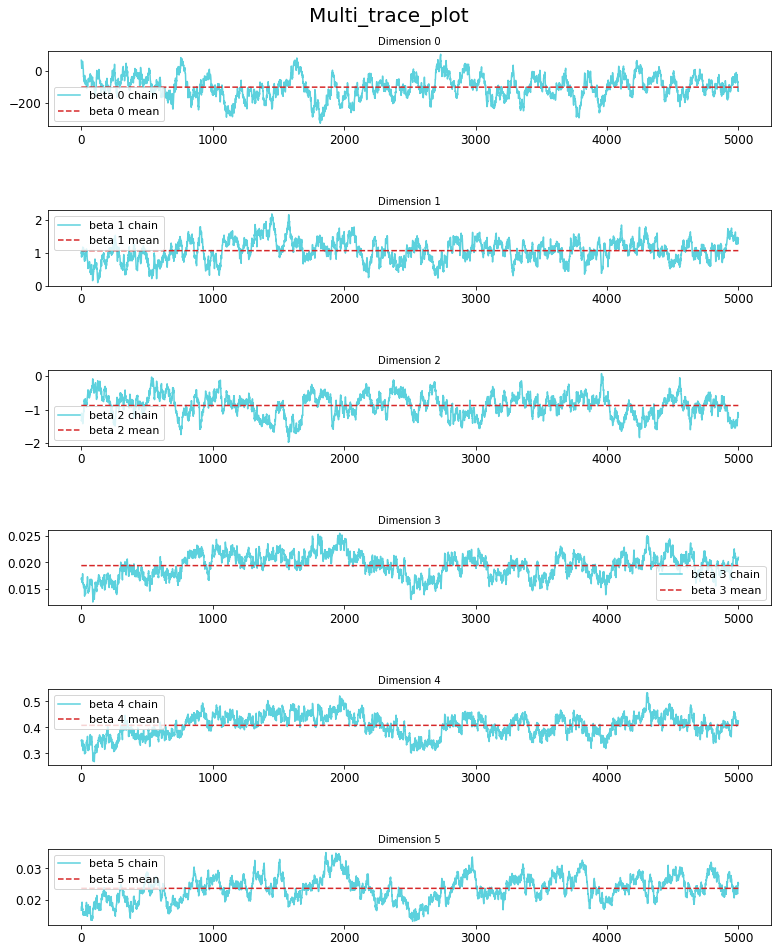

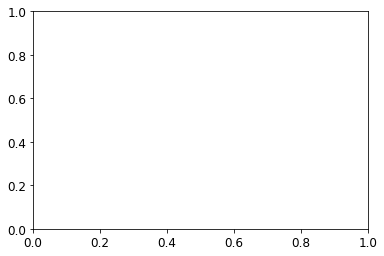

In [74]:
multi_plot_chain(values_, plot_trace_dimension, title = 'trace', plot_theta_true= False)

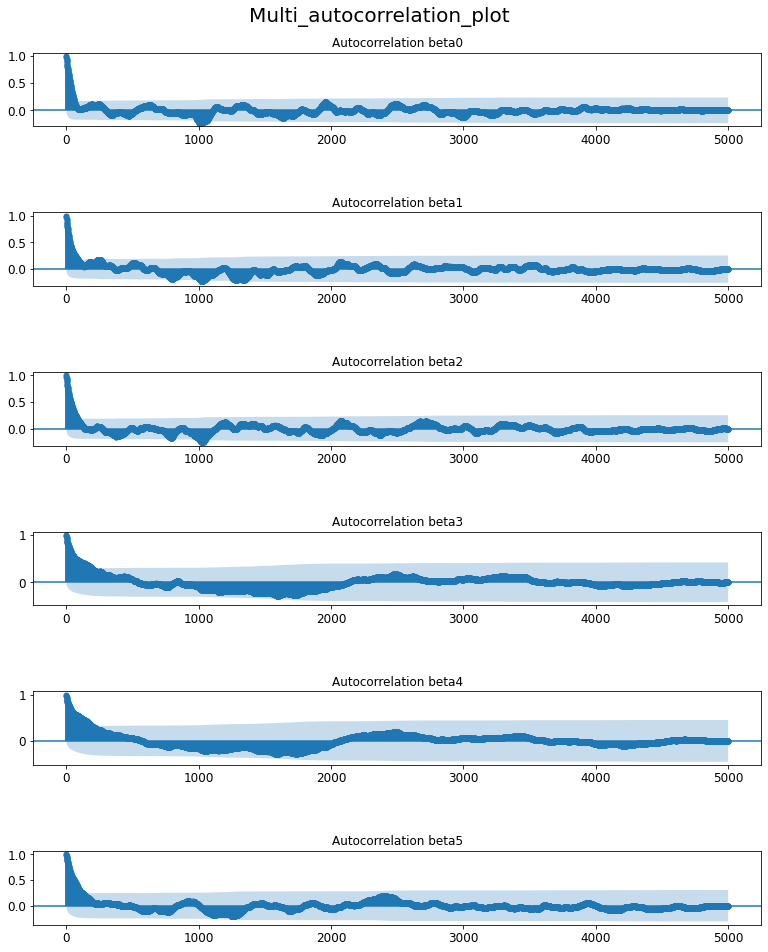

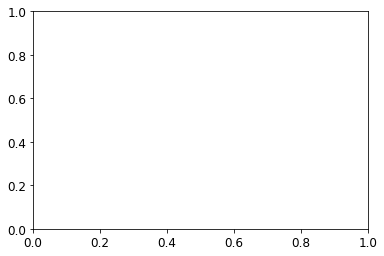

In [75]:
multi_plot_chain(values_, plot_autocorrelation, title = 'autocorrelation')

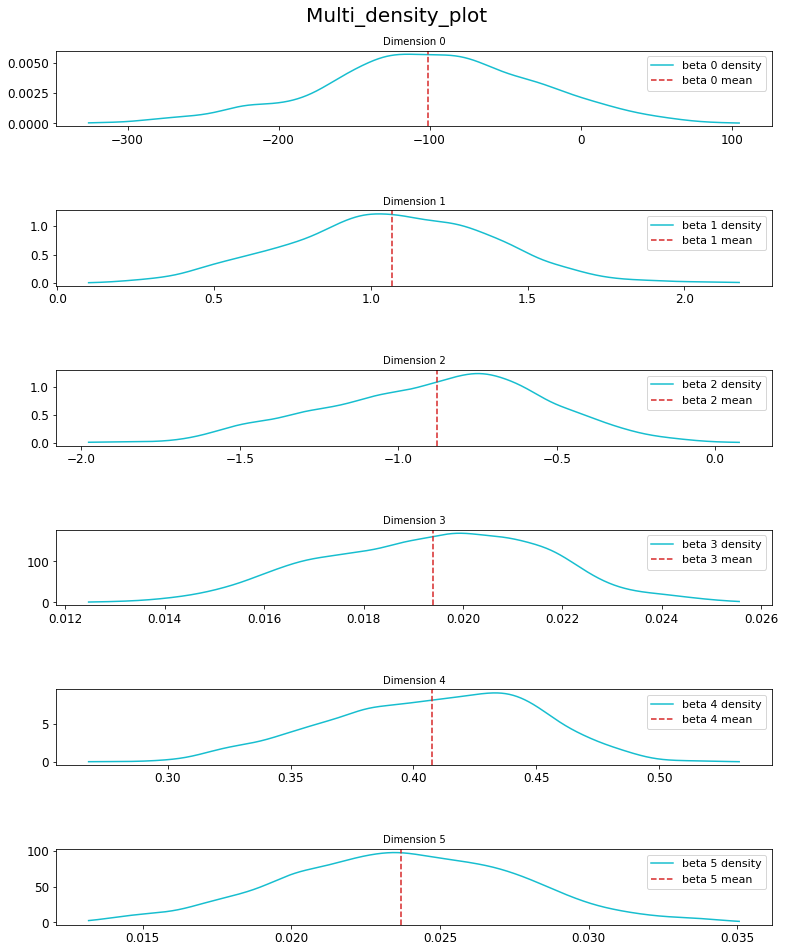

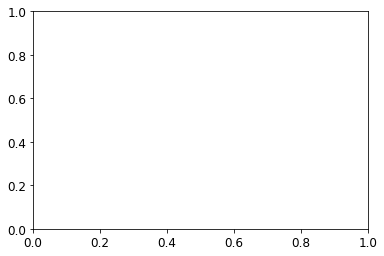

In [76]:
multi_plot_chain(values_, plot_density_dimension, title = 'density', plot_theta_true=False)